In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 16
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [13]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [14]:
perceptual_ext = PerceptualLoss()

In [15]:
sobel_filter = Sobel().to(device)

In [16]:
def train_a2b_epoch(generator, gen_optim, tf_discriminator, tf_d_optim, edge_discriminator, edge_d_optim, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    air_l = 0
    bone_l = 0

    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(tf_discriminator, True)
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = nn.CrossEntropyLoss()(y_cls.float(), torch.zeros(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))

        tf_dis.backward()
        tf_d_optim.step()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        set_requires_grad(edge_discriminator, True)
        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = nn.CrossEntropyLoss()(edge_y_cls.float(), torch.zeros(edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.ones(edge_pr_cls.size()[0], dtype=torch.long, device=device))

        edge_dis.backward()
        edge_d_optim.step()       
        
        tf_dis_l += tf_dis.item()
        edge_dis_l += edge_dis.item()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(tf_discriminator, False)
        set_requires_grad(edge_discriminator, False)
        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        tf_gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)        
        edge_gen = nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), edge_gen_l/(index+1), tf_gen_l/(index+1), edge_dis_l/(index+1), tf_dis_l/(index+1)

In [17]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
           
        _, y_cls = torch.max(y_cls.data, 1)
        correct = (y_cls == torch.zeros(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        _, y_pr_cls = torch.max(y_pr_cls.data, 1)
        correct = (y_pr_cls == torch.ones(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        edge_y_cls = Activation(name=DIS_ACT)(edge_y_cls)
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)

        _, edge_y_cls = torch.max(edge_y_cls.data, 1)
        correct = (edge_y_cls == torch.zeros(total, dtype=torch.long, device=edge_y_cls.device)).sum().item()
        edge_acc += [correct / total]
        _, edge_pr_cls = torch.max(edge_pr_cls.data, 1)
        correct = (edge_pr_cls == torch.ones(total, dtype=torch.long, device=edge_pr_cls.device)).sum().item()
        edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [18]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [19]:
from codes.activation import Activation
import torchvision.models as models

In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):

        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        self.bn1 = nn.InstanceNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_features=64, out_features=n_classes)

        self.activation = Activation(name=activation)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return self.activation(x)

# Generator

In [21]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [22]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [23]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [24]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [25]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [26]:
len(trainset), len(testset)

(1344, 191)

In [27]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7fbff61d4fd0>,)

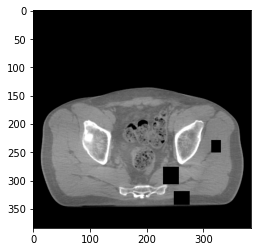

In [28]:
plt.imshow(x.squeeze(), 'gray'),

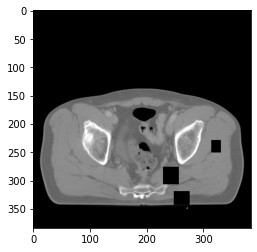

In [29]:
plt.imshow(y.squeeze(), 'gray')

In [30]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [31]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [34]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [35]:
edge_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [37]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

min_acc = 99

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis = train_a2b_epoch(model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer,
                                                                                             edge_discriminator, edge_dis_optimizer,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_tf_acc_test +  score_edge_acc_test <= min_acc:
            min_acc = score_tf_acc_test +  score_edge_acc_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

84it [01:26,  1.02s/it]
84it [00:26,  3.14it/s]
12it [00:04,  2.85it/s]
84it [01:24,  1.01s/it]
84it [00:26,  3.12it/s]
12it [00:04,  2.83it/s]
84it [01:25,  1.01s/it]
84it [00:26,  3.11it/s]
12it [00:04,  2.83it/s]
84it [01:24,  1.01s/it]
84it [00:26,  3.12it/s]
12it [00:04,  2.84it/s]
84it [01:25,  1.02s/it]
84it [00:26,  3.11it/s]
12it [00:04,  2.83it/s]
84it [01:25,  1.01s/it]
84it [00:26,  3.13it/s]
12it [00:04,  2.84it/s]
84it [01:25,  1.01s/it]
84it [00:26,  3.12it/s]
12it [00:04,  2.83it/s]
84it [01:25,  1.01s/it]
84it [00:27,  3.11it/s]
12it [00:04,  2.81it/s]
84it [01:25,  1.01s/it]
84it [00:27,  3.11it/s]
12it [00:04,  2.83it/s]
84it [01:25,  1.01s/it]
84it [00:26,  3.11it/s]
12it [00:04,  2.85it/s]
84it [01:25,  1.02s/it]
84it [00:26,  3.12it/s]
12it [00:04,  2.81it/s]
84it [01:25,  1.02s/it]
84it [00:27,  3.11it/s]
12it [00:04,  2.84it/s]
84it [01:25,  1.01s/it]
84it [00:26,  3.12it/s]
12it [00:04,  2.86it/s]
84it [01:25,  1.01s/it]
84it [00:26,  3.12it/s]
12it [00:04,  2.

In [38]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [39]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [40]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8299559950828552
psnr score = 21.731672286987305
snr score = 11.794609069824219
mae error = 0.03454684838652611
air dice score = 0.9971319594334909
bone dice score = 0.9249480866222939
contour dice score = 0.38948625326156616


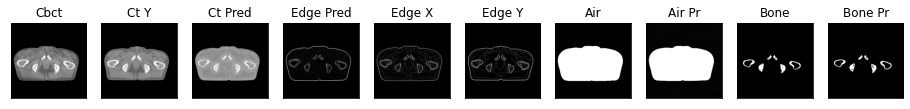

1it [00:00,  1.46it/s]

ssim score = 0.8298785090446472
psnr score = 21.72272491455078
snr score = 11.833198547363281
mae error = 0.03469432517886162
air dice score = 0.9972720916262103
bone dice score = 0.9233506300975041
contour dice score = 0.4335329234600067


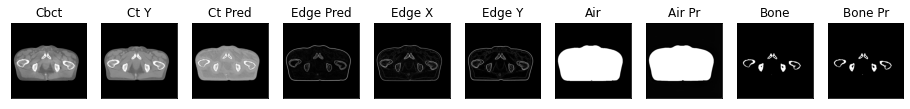

2it [00:01,  1.68it/s]

ssim score = 0.8279022574424744
psnr score = 21.79701805114746
snr score = 12.070387840270996
mae error = 0.0346214659512043
air dice score = 0.9972811096225104
bone dice score = 0.9115044247798798
contour dice score = 0.43045562505722046


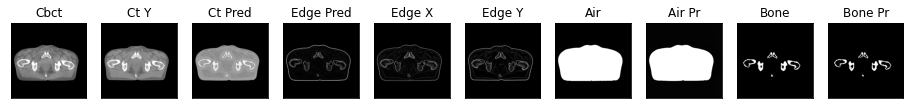

3it [00:01,  1.88it/s]

ssim score = 0.8239046335220337
psnr score = 21.831541061401367
snr score = 12.194165229797363
mae error = 0.03526941314339638
air dice score = 0.9978779055421232
bone dice score = 0.8783863023351894
contour dice score = 0.48048049211502075


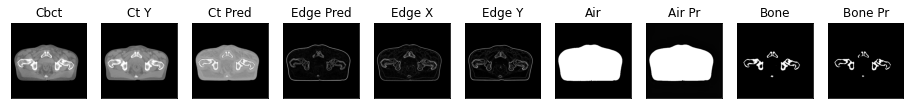

4it [00:01,  2.07it/s]

ssim score = 0.8228772282600403
psnr score = 21.77589225769043
snr score = 12.178815841674805
mae error = 0.03610078990459442
air dice score = 0.9976729217210499
bone dice score = 0.8668512995327348
contour dice score = 0.5090252757072449


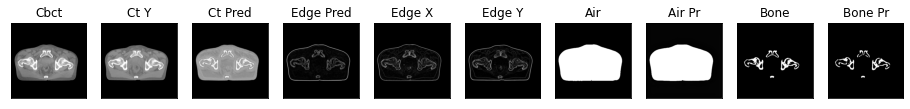

5it [00:02,  2.21it/s]

ssim score = 0.8232603669166565
psnr score = 21.755544662475586
snr score = 12.295005798339844
mae error = 0.03654305636882782
air dice score = 0.99775285367697
bone dice score = 0.84182156133976
contour dice score = 0.5157004594802856


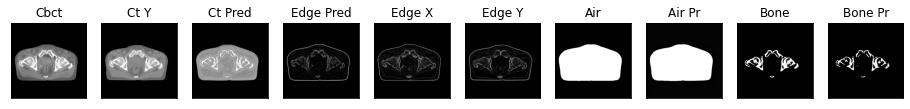

6it [00:02,  2.33it/s]

ssim score = 0.8211613297462463
psnr score = 21.633773803710938
snr score = 12.149173736572266
mae error = 0.03667720407247543
air dice score = 0.9973284772320249
bone dice score = 0.837408531145481
contour dice score = 0.5099939703941345


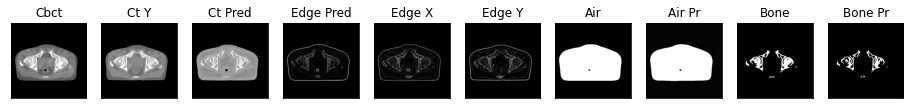

7it [00:02,  2.41it/s]

ssim score = 0.8264396786689758
psnr score = 21.893198013305664
snr score = 12.223063468933105
mae error = 0.03501944988965988
air dice score = 0.9970904185166197
bone dice score = 0.8665069477732007
contour dice score = 0.4748026728630066


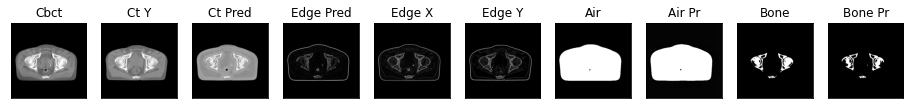

8it [00:03,  2.48it/s]

ssim score = 0.8349926471710205
psnr score = 22.196475982666016
snr score = 12.431788444519043
mae error = 0.033512894064188004
air dice score = 0.9970539104024327
bone dice score = 0.9005182400172694
contour dice score = 0.4875076115131378


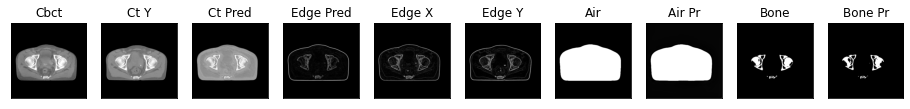

9it [00:03,  2.53it/s]

ssim score = 0.8390169739723206
psnr score = 22.30118751525879
snr score = 12.521214485168457
mae error = 0.03278328478336334
air dice score = 0.9967078105411251
bone dice score = 0.8897224306088337
contour dice score = 0.43031784892082214


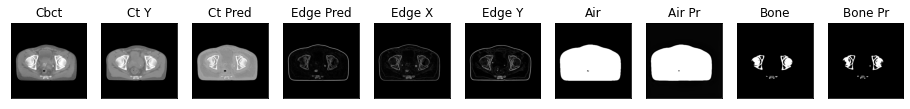

10it [00:04,  2.57it/s]

ssim score = 0.8470275402069092
psnr score = 22.60706329345703
snr score = 12.859359741210938
mae error = 0.03092947229743004
air dice score = 0.9965755531404469
bone dice score = 0.9188764044952934
contour dice score = 0.4428134560585022


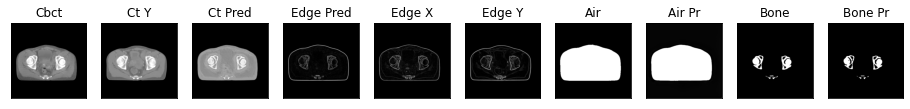

11it [00:04,  2.24it/s]

ssim score = 0.8473339080810547
psnr score = 22.247373580932617
snr score = 12.523382186889648
mae error = 0.031447138637304306
air dice score = 0.9963314541535438
bone dice score = 0.899714774673135
contour dice score = 0.44947949051856995


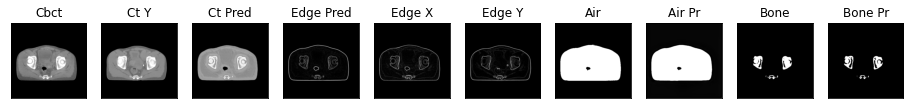

12it [00:05,  2.35it/s]

ssim score = 0.8530900478363037
psnr score = 22.063323974609375
snr score = 12.30740737915039
mae error = 0.03161078691482544
air dice score = 0.9959453088166001
bone dice score = 0.926532075021783
contour dice score = 0.4895705580711365


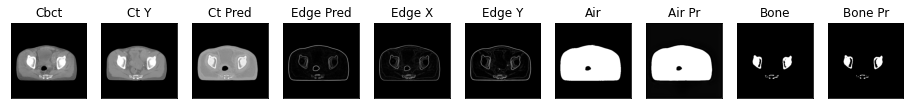

13it [00:05,  2.44it/s]

ssim score = 0.8521295785903931
psnr score = 21.901676177978516
snr score = 12.003805160522461
mae error = 0.03228556364774704
air dice score = 0.9961658304726737
bone dice score = 0.9046442045023463
contour dice score = 0.5200741291046143


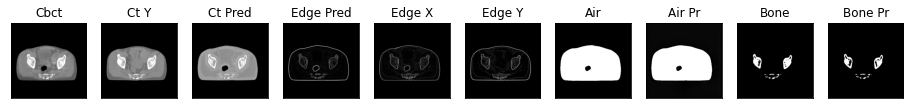

14it [00:05,  2.51it/s]

ssim score = 0.8499571084976196
psnr score = 21.751522064208984
snr score = 11.767990112304688
mae error = 0.032913897186517715
air dice score = 0.9966973568235192
bone dice score = 0.9051055139563634
contour dice score = 0.5509573817253113


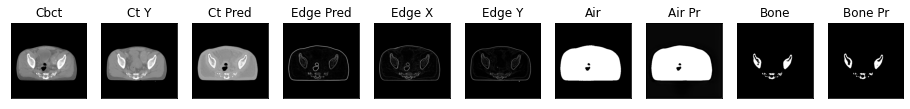

15it [00:06,  2.57it/s]

ssim score = 0.8434651494026184
psnr score = 21.44441795349121
snr score = 11.484369277954102
mae error = 0.03390512615442276
air dice score = 0.9975544900203996
bone dice score = 0.906335728283392
contour dice score = 0.6011270880699158


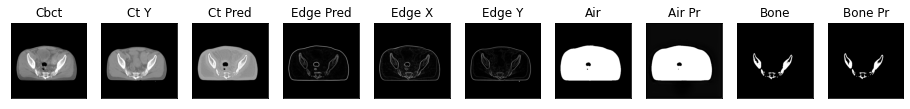

16it [00:06,  2.61it/s]

ssim score = 0.8384044766426086
psnr score = 20.82636260986328
snr score = 10.863770484924316
mae error = 0.036136578768491745
air dice score = 0.9974075914364132
bone dice score = 0.903306613227664
contour dice score = 0.6255506873130798


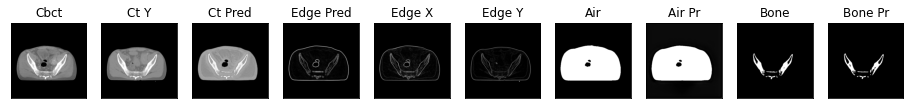

17it [00:06,  2.63it/s]

ssim score = 0.8318998217582703
psnr score = 20.344228744506836
snr score = 10.279874801635742
mae error = 0.03847283869981766
air dice score = 0.9964866339334463
bone dice score = 0.8805365730210005
contour dice score = 0.6658400297164917


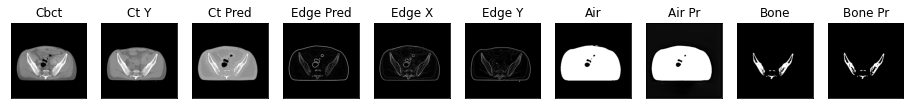

18it [00:07,  2.65it/s]

ssim score = 0.8293708562850952
psnr score = 20.041982650756836
snr score = 9.926947593688965
mae error = 0.040060389786958694
air dice score = 0.9955628775398182
bone dice score = 0.8801289202940359
contour dice score = 0.7257652878761292


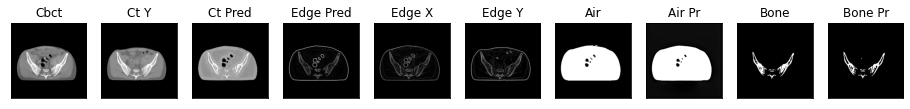

19it [00:07,  2.66it/s]

ssim score = 0.8345739245414734
psnr score = 20.114578247070312
snr score = 9.987234115600586
mae error = 0.03922479227185249
air dice score = 0.9964639321075004
bone dice score = 0.889882473174631
contour dice score = 0.6882129311561584


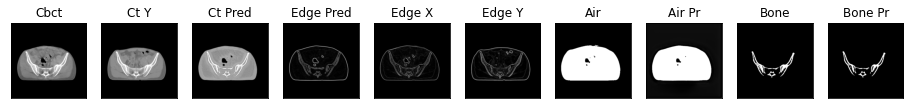

20it [00:08,  2.67it/s]

ssim score = 0.8312327265739441
psnr score = 20.060503005981445
snr score = 9.86831283569336
mae error = 0.038866739720106125
air dice score = 0.9962317160185558
bone dice score = 0.8766859344910999
contour dice score = 0.6525641083717346


21it [00:08,  2.30it/s]

ssim score = 0.8287205100059509
psnr score = 19.944778442382812
snr score = 9.693156242370605
mae error = 0.03894205018877983
air dice score = 0.9946372876792305
bone dice score = 0.8852546916905462
contour dice score = 0.6343669295310974


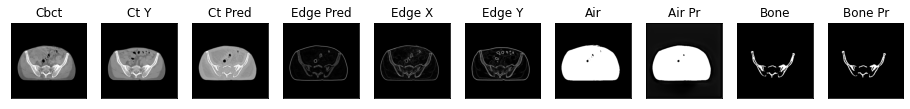

22it [00:08,  2.40it/s]

ssim score = 0.8373688459396362
psnr score = 20.036571502685547
snr score = 9.751522064208984
mae error = 0.03828628733754158
air dice score = 0.9947849352651806
bone dice score = 0.883206106871715
contour dice score = 0.635064959526062


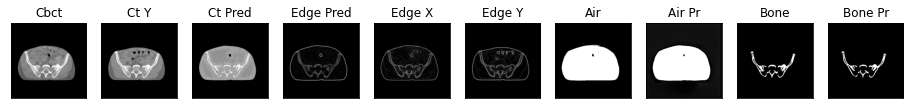

23it [00:09,  2.48it/s]

ssim score = 0.8370853662490845
psnr score = 19.91815757751465
snr score = 9.584545135498047
mae error = 0.03906100243330002
air dice score = 0.9946517939967308
bone dice score = 0.8836301536974428
contour dice score = 0.6243386268615723


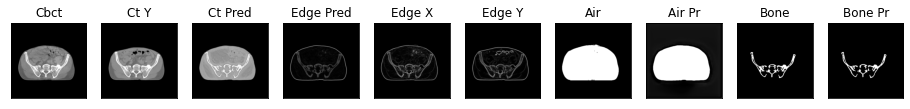

24it [00:09,  2.54it/s]

ssim score = 0.8354203701019287
psnr score = 19.83487892150879
snr score = 9.404266357421875
mae error = 0.039292532950639725
air dice score = 0.9945694517123151
bone dice score = 0.8728440585241721
contour dice score = 0.5446009635925293


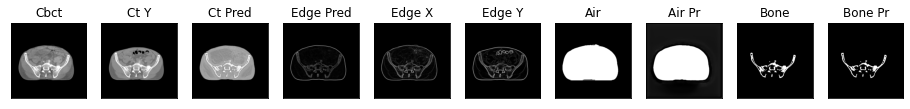

25it [00:10,  2.59it/s]

ssim score = 0.8344963192939758
psnr score = 19.88669204711914
snr score = 9.373344421386719
mae error = 0.0394059419631958
air dice score = 0.9944869540421148
bone dice score = 0.8564576088277196
contour dice score = 0.6145479083061218


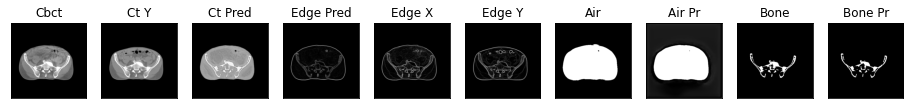

26it [00:10,  2.62it/s]

ssim score = 0.8362193703651428
psnr score = 19.962852478027344
snr score = 9.358319282531738
mae error = 0.03910701721906662
air dice score = 0.9933981805627979
bone dice score = 0.852229601519779
contour dice score = 0.6685236692428589


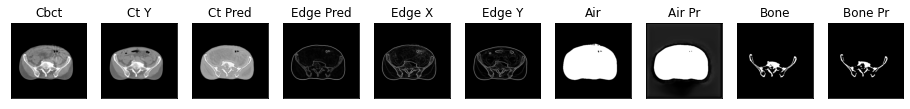

27it [00:10,  2.67it/s]

ssim score = 0.836489737033844
psnr score = 19.946439743041992
snr score = 9.300799369812012
mae error = 0.038947634398937225
air dice score = 0.992629898046932
bone dice score = 0.8608137044983566
contour dice score = 0.6619619131088257


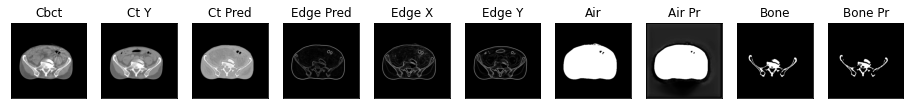

28it [00:11,  2.69it/s]

ssim score = 0.8021700978279114
psnr score = 21.32483673095703
snr score = 12.696991920471191
mae error = 0.041776880621910095
air dice score = 0.9920489753256984
bone dice score = 0.9466543324099089
contour dice score = 0.1422487199306488


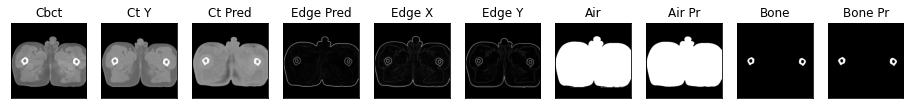

29it [00:11,  2.71it/s]

ssim score = 0.8039640188217163
psnr score = 21.629745483398438
snr score = 13.04116153717041
mae error = 0.040814656764268875
air dice score = 0.9915667177961403
bone dice score = 0.949191685913707
contour dice score = 0.1421319842338562


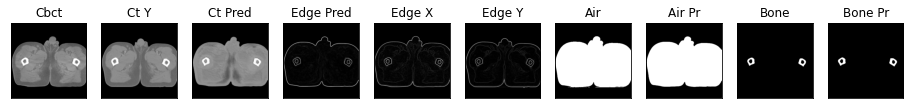

30it [00:12,  2.34it/s]

ssim score = 0.8047087788581848
psnr score = 21.931743621826172
snr score = 13.430606842041016
mae error = 0.04072873666882515
air dice score = 0.9917663754924321
bone dice score = 0.943255813954808
contour dice score = 0.15199999511241913


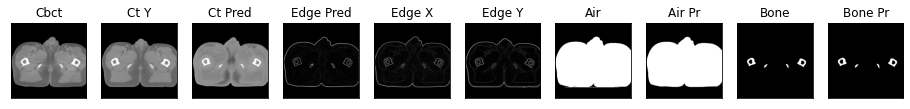

31it [00:12,  2.46it/s]

ssim score = 0.8045557737350464
psnr score = 22.23993682861328
snr score = 13.901359558105469
mae error = 0.04019022732973099
air dice score = 0.9926904318848028
bone dice score = 0.9384057971024636
contour dice score = 0.1584523320198059


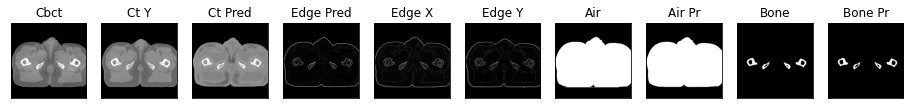

32it [00:12,  2.55it/s]

ssim score = 0.8016419410705566
psnr score = 22.39316177368164
snr score = 14.18272590637207
mae error = 0.039703208953142166
air dice score = 0.9926131340897851
bone dice score = 0.9227226939139053
contour dice score = 0.1560613065958023


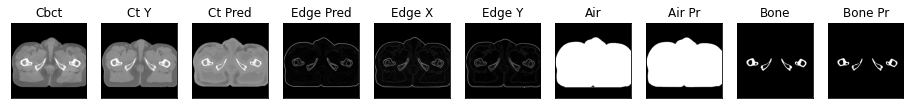

33it [00:13,  2.59it/s]

ssim score = 0.8006653785705566
psnr score = 22.763912200927734
snr score = 14.65671443939209
mae error = 0.037972643971443176
air dice score = 0.9929260217466075
bone dice score = 0.9043367346950978
contour dice score = 0.16029822826385498


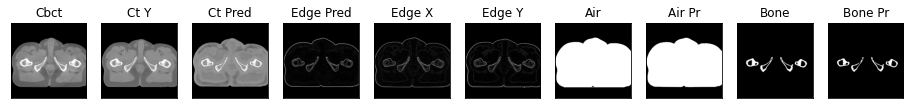

34it [00:13,  2.64it/s]

ssim score = 0.8001688122749329
psnr score = 22.950939178466797
snr score = 14.910841941833496
mae error = 0.03792615607380867
air dice score = 0.9928816430489438
bone dice score = 0.8910867492863311
contour dice score = 0.15914379060268402


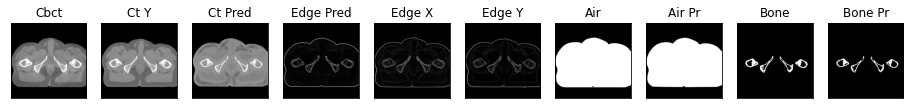

35it [00:13,  2.67it/s]

ssim score = 0.7959293723106384
psnr score = 22.966793060302734
snr score = 14.916805267333984
mae error = 0.038074836134910583
air dice score = 0.9930888271368382
bone dice score = 0.9042050820788823
contour dice score = 0.16048237681388855


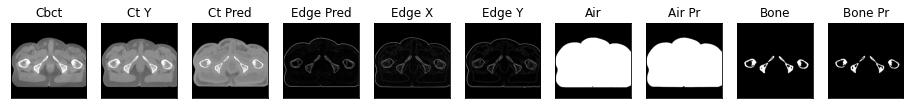

36it [00:14,  2.70it/s]

ssim score = 0.7949129939079285
psnr score = 23.02036476135254
snr score = 14.95671272277832
mae error = 0.03788473829627037
air dice score = 0.9931755706943988
bone dice score = 0.9002018389784682
contour dice score = 0.15777261555194855


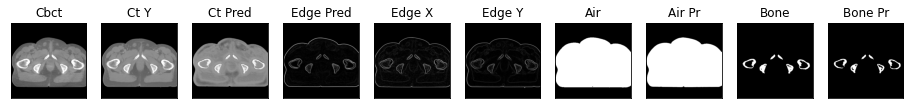

37it [00:14,  2.72it/s]

ssim score = 0.8050764203071594
psnr score = 23.355308532714844
snr score = 15.303655624389648
mae error = 0.03651494160294533
air dice score = 0.9932252962067668
bone dice score = 0.8909545942093795
contour dice score = 0.15828678011894226


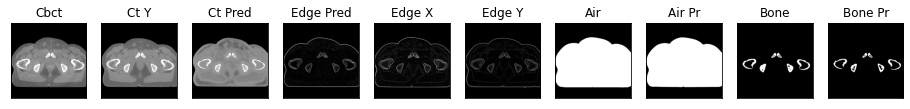

38it [00:15,  2.71it/s]

ssim score = 0.8086622357368469
psnr score = 23.4461612701416
snr score = 15.433595657348633
mae error = 0.03593723103404045
air dice score = 0.9930483038458138
bone dice score = 0.8957294074717638
contour dice score = 0.15678954124450684


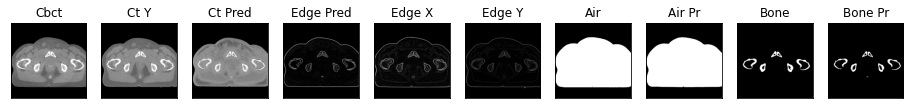

39it [00:15,  2.72it/s]

ssim score = 0.8033859133720398
psnr score = 23.52201271057129
snr score = 15.650735855102539
mae error = 0.03553495928645134
air dice score = 0.9929986450915947
bone dice score = 0.8801525908670113
contour dice score = 0.15816564857959747


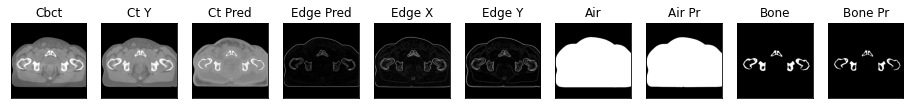

40it [00:15,  2.34it/s]

ssim score = 0.797313392162323
psnr score = 23.498441696166992
snr score = 15.721851348876953
mae error = 0.03620391711592674
air dice score = 0.9929061907977739
bone dice score = 0.8458269282950915
contour dice score = 0.16705772280693054


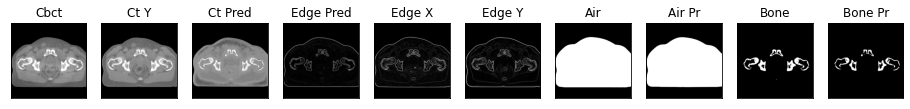

41it [00:16,  2.45it/s]

ssim score = 0.7768480777740479
psnr score = 22.725297927856445
snr score = 14.914661407470703
mae error = 0.03857621178030968
air dice score = 0.9928463923151228
bone dice score = 0.8237068583104986
contour dice score = 0.17669172585010529


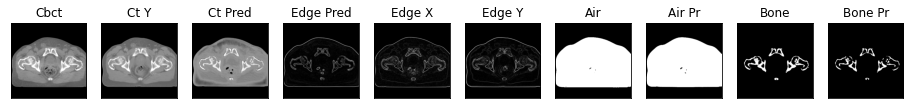

42it [00:16,  2.53it/s]

ssim score = 0.7684990763664246
psnr score = 22.032180786132812
snr score = 14.293728828430176
mae error = 0.04031910374760628
air dice score = 0.9917889271267332
bone dice score = 0.7498794406064148
contour dice score = 0.18018868565559387


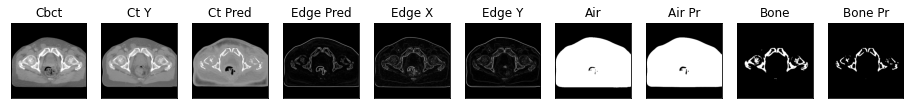

43it [00:17,  2.59it/s]

ssim score = 0.7786600589752197
psnr score = 22.2100830078125
snr score = 14.335537910461426
mae error = 0.03918226808309555
air dice score = 0.9924539728682217
bone dice score = 0.8028113244921519
contour dice score = 0.18516768515110016


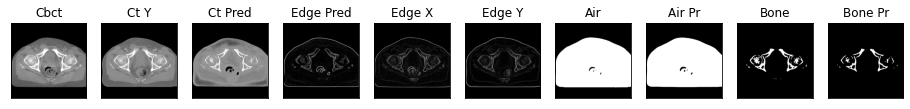

44it [00:17,  2.64it/s]

ssim score = 0.7904353141784668
psnr score = 22.354047775268555
snr score = 14.300942420959473
mae error = 0.03821703791618347
air dice score = 0.9927631259410409
bone dice score = 0.8317276814404653
contour dice score = 0.18708452582359314


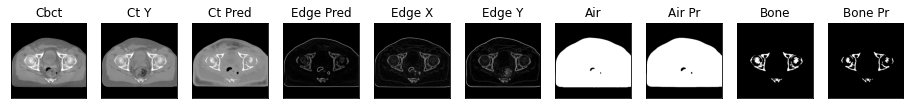

45it [00:17,  2.67it/s]

ssim score = 0.7927847504615784
psnr score = 22.338680267333984
snr score = 14.194986343383789
mae error = 0.038783468306064606
air dice score = 0.9931492276924427
bone dice score = 0.8363636363655809
contour dice score = 0.19056694209575653


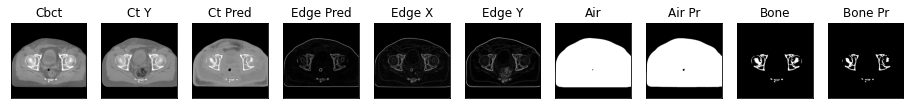

46it [00:18,  2.68it/s]

ssim score = 0.803874671459198
psnr score = 22.408220291137695
snr score = 14.2802152633667
mae error = 0.038735728710889816
air dice score = 0.9935910738918701
bone dice score = 0.8534549905435244
contour dice score = 0.19656488299369812


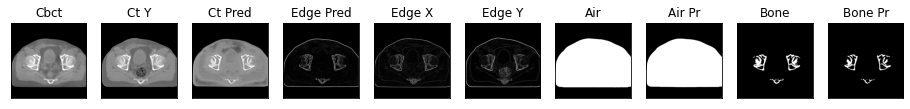

47it [00:18,  2.68it/s]

ssim score = 0.7918656468391418
psnr score = 22.098539352416992
snr score = 13.980569839477539
mae error = 0.04040868207812309
air dice score = 0.9936451074688428
bone dice score = 0.8461302525319893
contour dice score = 0.19980879127979279


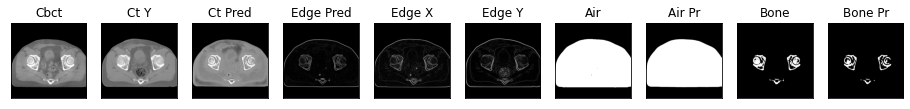

48it [00:18,  2.69it/s]

ssim score = 0.8039887547492981
psnr score = 22.38704490661621
snr score = 14.330665588378906
mae error = 0.039611827582120895
air dice score = 0.9936913371287929
bone dice score = 0.8385332252852661
contour dice score = 0.20076481997966766


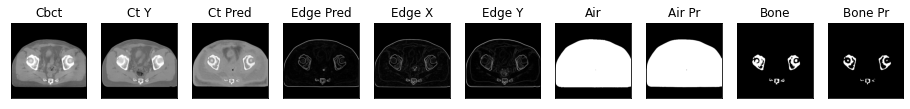

49it [00:19,  2.29it/s]

ssim score = 0.8018168807029724
psnr score = 22.776134490966797
snr score = 14.789834976196289
mae error = 0.038234081119298935
air dice score = 0.9933934156226331
bone dice score = 0.888211769187886
contour dice score = 0.1928400993347168


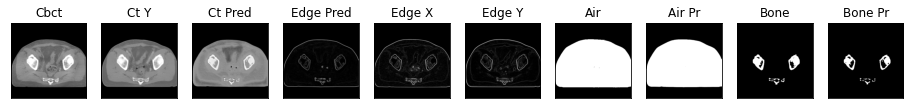

50it [00:19,  2.39it/s]

ssim score = 0.8060442209243774
psnr score = 22.648313522338867
snr score = 14.542908668518066
mae error = 0.03822178393602371
air dice score = 0.9933309067128999
bone dice score = 0.8638900815815382
contour dice score = 0.18121124804019928


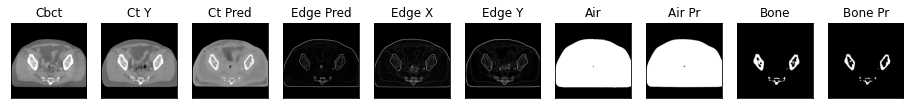

51it [00:20,  2.48it/s]

ssim score = 0.7921194434165955
psnr score = 22.03664779663086
snr score = 14.012871742248535
mae error = 0.04116717725992203
air dice score = 0.9930202732698706
bone dice score = 0.8570889894432778
contour dice score = 0.17162032425403595


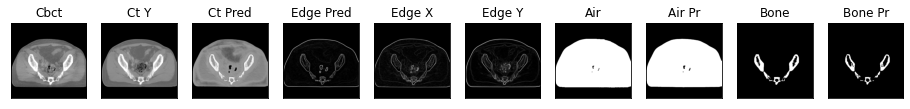

52it [00:20,  2.54it/s]

ssim score = 0.7897023558616638
psnr score = 22.132530212402344
snr score = 14.1889009475708
mae error = 0.041380129754543304
air dice score = 0.9918840365526295
bone dice score = 0.8166067342283704
contour dice score = 0.16065415740013123


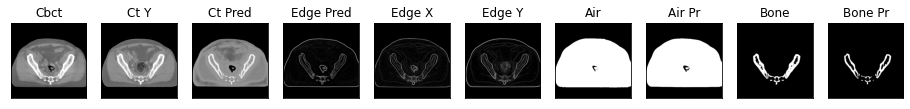

53it [00:20,  2.58it/s]

ssim score = 0.7657804489135742
psnr score = 21.732513427734375
snr score = 13.810442924499512
mae error = 0.04372009262442589
air dice score = 0.992471784543215
bone dice score = 0.8021886917608839
contour dice score = 0.1477547138929367


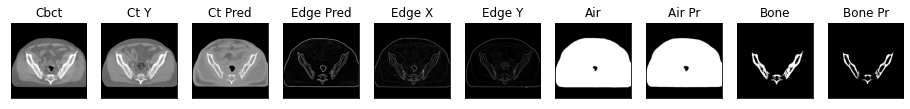

54it [00:21,  2.61it/s]

ssim score = 0.766139566898346
psnr score = 22.103248596191406
snr score = 14.19371509552002
mae error = 0.04264865443110466
air dice score = 0.9925589438815322
bone dice score = 0.8152282572491234
contour dice score = 0.12608277797698975


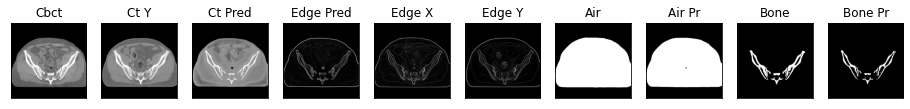

55it [00:21,  2.65it/s]

ssim score = 0.788101315498352
psnr score = 19.029621124267578
snr score = 8.909828186035156
mae error = 0.04626607149839401
air dice score = 0.996088890479987
bone dice score = 0.9296071711065224
contour dice score = 0.37562325596809387


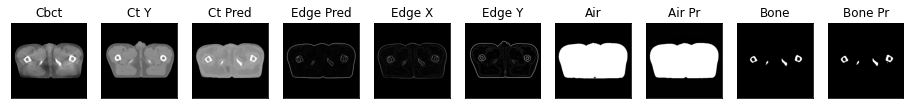

56it [00:22,  2.69it/s]

ssim score = 0.7791938185691833
psnr score = 18.88123893737793
snr score = 8.974428176879883
mae error = 0.047266885638237
air dice score = 0.9960929504009433
bone dice score = 0.9038896892384464
contour dice score = 0.35170891880989075


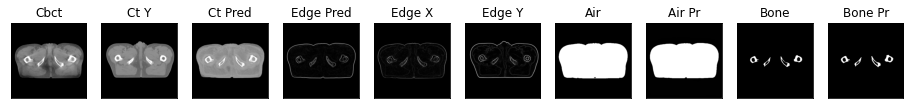

57it [00:22,  2.72it/s]

ssim score = 0.7738202810287476
psnr score = 18.888046264648438
snr score = 9.112372398376465
mae error = 0.047548808157444
air dice score = 0.996077459114377
bone dice score = 0.8800926819872544
contour dice score = 0.36043956875801086


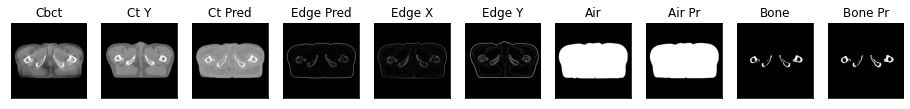

58it [00:22,  2.74it/s]

ssim score = 0.7755357027053833
psnr score = 19.112829208374023
snr score = 9.40755844116211
mae error = 0.04670681431889534
air dice score = 0.9950098744533828
bone dice score = 0.8771929824584324
contour dice score = 0.31925398111343384


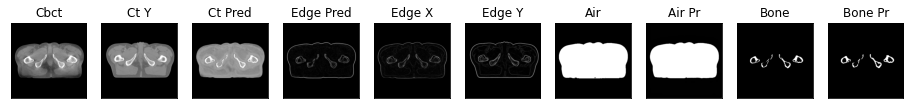

59it [00:23,  2.34it/s]

ssim score = 0.7774066925048828
psnr score = 19.23822021484375
snr score = 9.58051586151123
mae error = 0.04618954658508301
air dice score = 0.9947014630288699
bone dice score = 0.8911577028278731
contour dice score = 0.3286026120185852


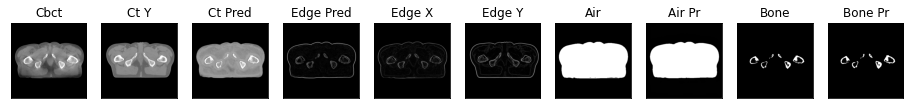

60it [00:23,  2.46it/s]

ssim score = 0.7767525911331177
psnr score = 19.31818199157715
snr score = 9.666093826293945
mae error = 0.045741718262434006
air dice score = 0.994209830149183
bone dice score = 0.8957337581891355
contour dice score = 0.3404255211353302


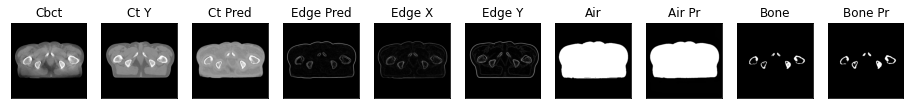

61it [00:24,  2.54it/s]

ssim score = 0.7746661901473999
psnr score = 19.321569442749023
snr score = 9.66297721862793
mae error = 0.04581715911626816
air dice score = 0.9936415882055011
bone dice score = 0.8987663280134476
contour dice score = 0.3493077754974365


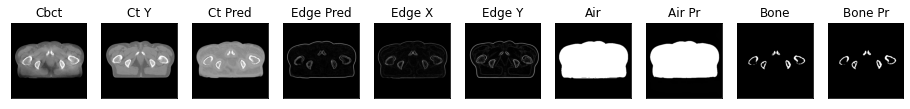

62it [00:24,  2.58it/s]

ssim score = 0.7758027911186218
psnr score = 19.23611831665039
snr score = 9.59163761138916
mae error = 0.046180177479982376
air dice score = 0.9938794521979175
bone dice score = 0.9036166043131371
contour dice score = 0.3234042525291443


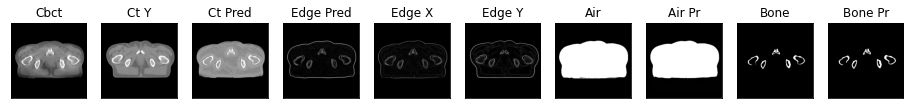

63it [00:24,  2.62it/s]

ssim score = 0.7729666233062744
psnr score = 19.203195571899414
snr score = 9.616721153259277
mae error = 0.04610199108719826
air dice score = 0.9946870951192623
bone dice score = 0.896913776648156
contour dice score = 0.3122994601726532


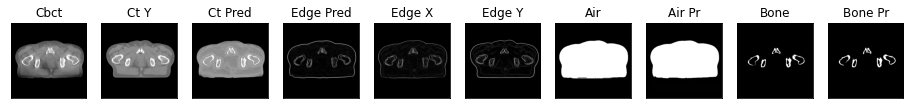

64it [00:25,  2.64it/s]

ssim score = 0.7625880837440491
psnr score = 19.06984519958496
snr score = 9.581932067871094
mae error = 0.04759715870022774
air dice score = 0.993980397259091
bone dice score = 0.8726142920569224
contour dice score = 0.3190702497959137


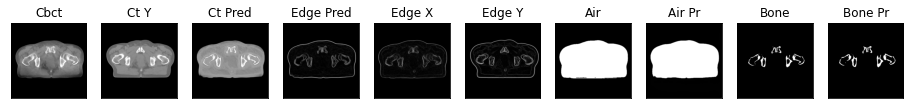

65it [00:25,  2.67it/s]

ssim score = 0.754503071308136
psnr score = 18.950908660888672
snr score = 9.498823165893555
mae error = 0.04853693023324013
air dice score = 0.9937650461559832
bone dice score = 0.8731707317091367
contour dice score = 0.2528240978717804


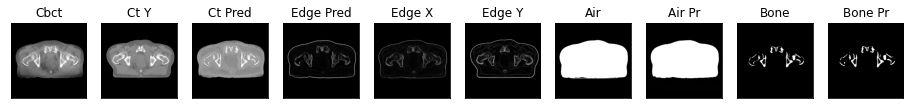

66it [00:25,  2.69it/s]

ssim score = 0.7476606369018555
psnr score = 18.866867065429688
snr score = 9.447489738464355
mae error = 0.049996212124824524
air dice score = 0.994430318440494
bone dice score = 0.8461738002613985
contour dice score = 0.2851041257381439


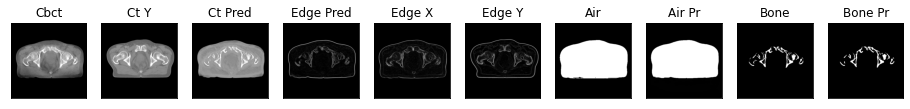

67it [00:26,  2.70it/s]

ssim score = 0.7484002113342285
psnr score = 19.04168128967285
snr score = 9.739120483398438
mae error = 0.04879148676991463
air dice score = 0.994856634077613
bone dice score = 0.8650665340148606
contour dice score = 0.3106180727481842


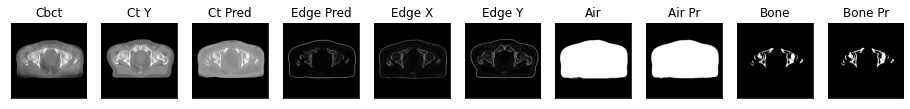

68it [00:26,  2.33it/s]

ssim score = 0.7553339004516602
psnr score = 19.08790397644043
snr score = 9.769354820251465
mae error = 0.04887600615620613
air dice score = 0.9950306372019505
bone dice score = 0.8571428571447735
contour dice score = 0.3257080614566803


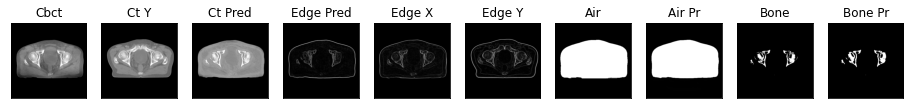

69it [00:27,  2.43it/s]

ssim score = 0.7687733173370361
psnr score = 19.375640869140625
snr score = 9.857931137084961
mae error = 0.04714420810341835
air dice score = 0.9949055365592556
bone dice score = 0.8927847000884848
contour dice score = 0.3084363341331482


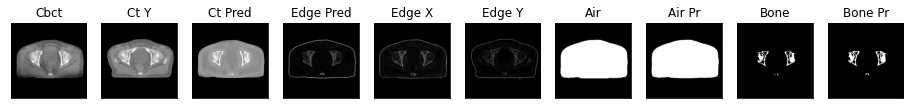

70it [00:27,  2.52it/s]

ssim score = 0.7800564765930176
psnr score = 19.72007942199707
snr score = 10.031976699829102
mae error = 0.04513532668352127
air dice score = 0.9948449164669619
bone dice score = 0.9174362508626128
contour dice score = 0.2898706793785095


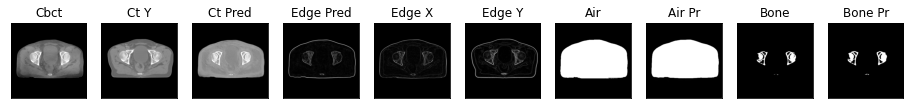

71it [00:27,  2.58it/s]

ssim score = 0.7838300466537476
psnr score = 19.968721389770508
snr score = 10.294785499572754
mae error = 0.04415025934576988
air dice score = 0.9948291734420887
bone dice score = 0.9302074912431931
contour dice score = 0.3153393864631653


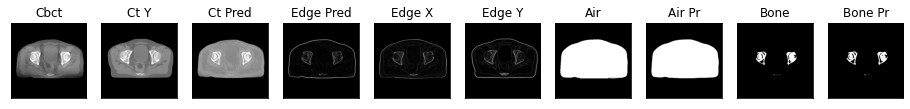

72it [00:28,  2.62it/s]

ssim score = 0.7906296849250793
psnr score = 20.2570743560791
snr score = 10.664968490600586
mae error = 0.042727213352918625
air dice score = 0.9943484385199485
bone dice score = 0.9213389121349883
contour dice score = 0.30000001192092896


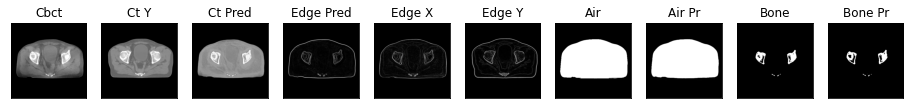

73it [00:28,  2.65it/s]

ssim score = 0.7864285111427307
psnr score = 20.330678939819336
snr score = 10.830745697021484
mae error = 0.0423625186085701
air dice score = 0.994424794676583
bone dice score = 0.9185431464422164
contour dice score = 0.2975206673145294


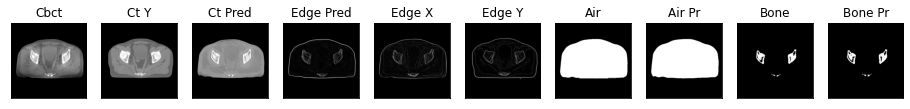

74it [00:29,  2.68it/s]

ssim score = 0.788404107093811
psnr score = 20.584964752197266
snr score = 11.021602630615234
mae error = 0.041109003126621246
air dice score = 0.9949252432898114
bone dice score = 0.9364124247855519
contour dice score = 0.27727028727531433


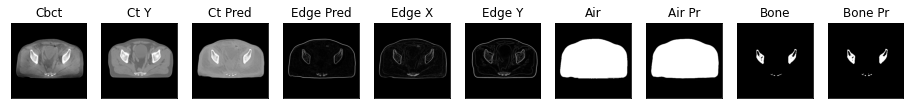

75it [00:29,  2.69it/s]

ssim score = 0.7888719439506531
psnr score = 20.646045684814453
snr score = 11.046289443969727
mae error = 0.040924813598394394
air dice score = 0.9943982606471463
bone dice score = 0.9252009786800909
contour dice score = 0.2977588176727295


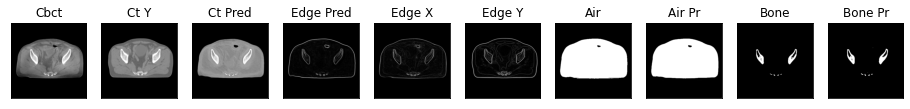

76it [00:29,  2.71it/s]

ssim score = 0.7852151393890381
psnr score = 20.57430648803711
snr score = 11.012296676635742
mae error = 0.0418214350938797
air dice score = 0.9944994499449992
bone dice score = 0.8886689757564131
contour dice score = 0.3055703043937683


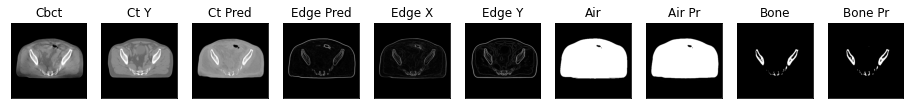

77it [00:30,  2.72it/s]

ssim score = 0.7795807719230652
psnr score = 20.501495361328125
snr score = 11.069990158081055
mae error = 0.04285452142357826
air dice score = 0.9947858441214917
bone dice score = 0.8916728076655612
contour dice score = 0.3229946494102478


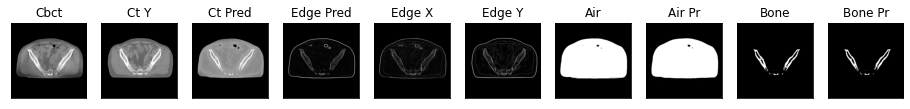

78it [00:30,  2.33it/s]

ssim score = 0.7815845608711243
psnr score = 20.38158416748047
snr score = 10.967827796936035
mae error = 0.04374878853559494
air dice score = 0.995083427553367
bone dice score = 0.8645897594098614
contour dice score = 0.2970936596393585


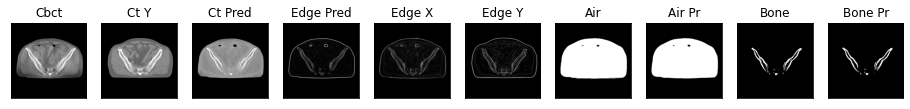

79it [00:31,  2.44it/s]

ssim score = 0.781682014465332
psnr score = 20.716426849365234
snr score = 11.291400909423828
mae error = 0.042417772114276886
air dice score = 0.9953322043514555
bone dice score = 0.8726155835778756
contour dice score = 0.3347732126712799


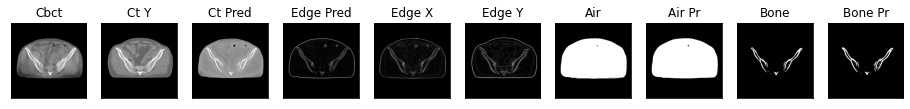

80it [00:31,  2.52it/s]

ssim score = 0.7838914394378662
psnr score = 20.75257110595703
snr score = 11.326805114746094
mae error = 0.04222670942544937
air dice score = 0.995522040362037
bone dice score = 0.8666460396060234
contour dice score = 0.3240589201450348


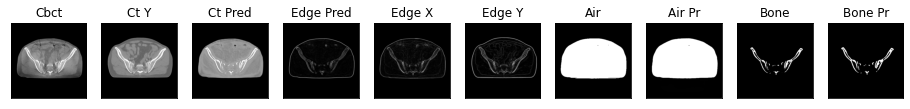

81it [00:31,  2.57it/s]

ssim score = 0.7977499961853027
psnr score = 20.990909576416016
snr score = 11.42504596710205
mae error = 0.04032019153237343
air dice score = 0.9940763124445451
bone dice score = 0.8886569241514037
contour dice score = 0.23604466021060944


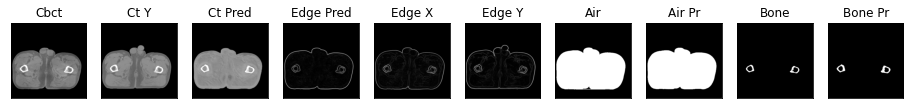

82it [00:32,  2.62it/s]

ssim score = 0.799062967300415
psnr score = 21.242755889892578
snr score = 11.74128532409668
mae error = 0.0393282026052475
air dice score = 0.993811714051942
bone dice score = 0.8845663265342931
contour dice score = 0.22550052404403687


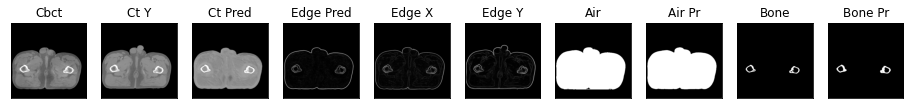

83it [00:32,  2.65it/s]

ssim score = 0.8067010045051575
psnr score = 22.040279388427734
snr score = 12.678017616271973
mae error = 0.03678889572620392
air dice score = 0.9942510681075692
bone dice score = 0.9158190867795755
contour dice score = 0.2282221019268036


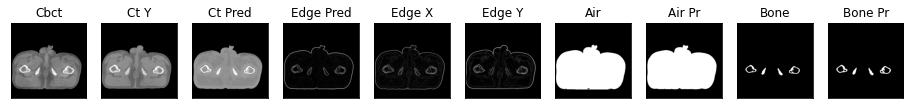

84it [00:32,  2.68it/s]

ssim score = 0.8073299527168274
psnr score = 22.12407875061035
snr score = 12.883310317993164
mae error = 0.03612299636006355
air dice score = 0.9949448780754636
bone dice score = 0.8846386148603858
contour dice score = 0.2346886247396469


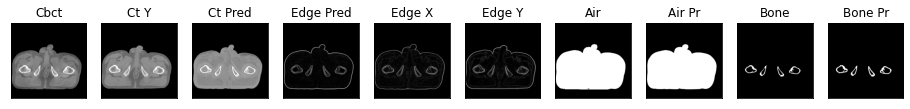

85it [00:33,  2.69it/s]

ssim score = 0.8017278909683228
psnr score = 21.96564483642578
snr score = 12.74904727935791
mae error = 0.0367141030728817
air dice score = 0.9950425591619158
bone dice score = 0.8510551948082172
contour dice score = 0.21714285016059875


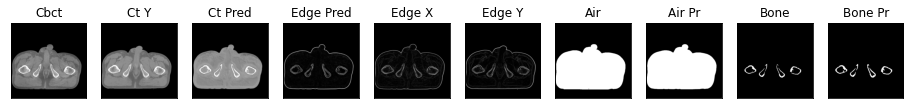

86it [00:33,  2.71it/s]

ssim score = 0.7972155213356018
psnr score = 21.720870971679688
snr score = 12.499876976013184
mae error = 0.037847425788640976
air dice score = 0.9952515879935272
bone dice score = 0.8599141951154651
contour dice score = 0.2075471729040146


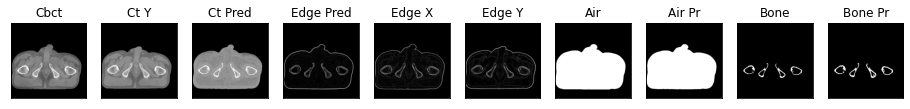

87it [00:34,  2.33it/s]

ssim score = 0.7972707748413086
psnr score = 21.460811614990234
snr score = 12.246073722839355
mae error = 0.03845229372382164
air dice score = 0.9952547646830064
bone dice score = 0.8759962928660613
contour dice score = 0.18536071479320526


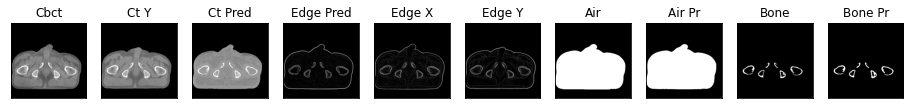

88it [00:34,  2.44it/s]

ssim score = 0.7978399991989136
psnr score = 21.346235275268555
snr score = 12.109939575195312
mae error = 0.0385897234082222
air dice score = 0.9953359443739379
bone dice score = 0.8816326530634205
contour dice score = 0.2015831172466278


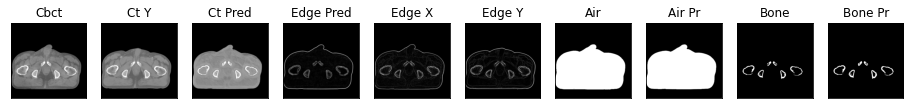

89it [00:34,  2.52it/s]

ssim score = 0.7999034523963928
psnr score = 21.4040584564209
snr score = 12.184676170349121
mae error = 0.03843463957309723
air dice score = 0.9951284253259465
bone dice score = 0.8958777540885594
contour dice score = 0.2068965584039688


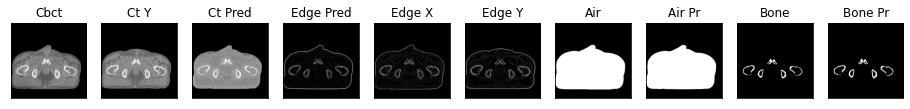

90it [00:35,  2.57it/s]

ssim score = 0.800176739692688
psnr score = 21.709495544433594
snr score = 12.558704376220703
mae error = 0.03718432039022446
air dice score = 0.9953999388748302
bone dice score = 0.8932793522284489
contour dice score = 0.19893048703670502


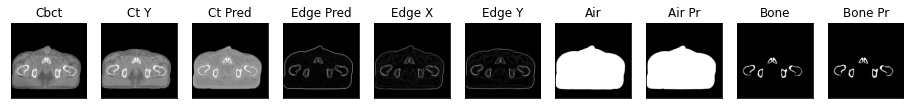

91it [00:35,  2.61it/s]

ssim score = 0.7972807884216309
psnr score = 22.03400421142578
snr score = 12.96457290649414
mae error = 0.036278270184993744
air dice score = 0.9955863262656893
bone dice score = 0.8968003605243082
contour dice score = 0.20956474542617798


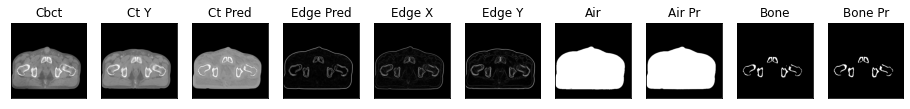

92it [00:36,  2.64it/s]

ssim score = 0.7965421676635742
psnr score = 22.23137092590332
snr score = 13.212642669677734
mae error = 0.036337971687316895
air dice score = 0.995836723730678
bone dice score = 0.8700725772040689
contour dice score = 0.21420882642269135


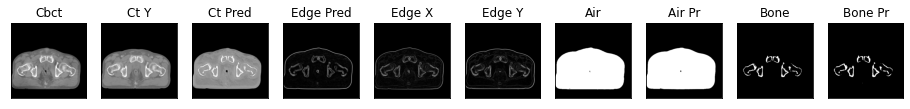

93it [00:36,  2.67it/s]

ssim score = 0.7984673380851746
psnr score = 22.677526473999023
snr score = 13.775067329406738
mae error = 0.03473378345370293
air dice score = 0.9957851370622756
bone dice score = 0.8523692139160179
contour dice score = 0.21970920264720917


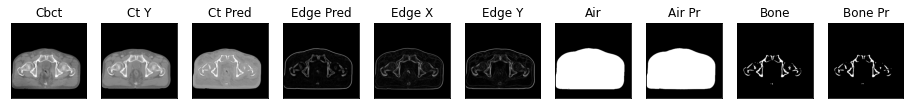

94it [00:36,  2.65it/s]

ssim score = 0.8012945055961609
psnr score = 22.29781723022461
snr score = 13.357120513916016
mae error = 0.03637107461690903
air dice score = 0.9956905135537765
bone dice score = 0.8385930766044961
contour dice score = 0.2521551847457886


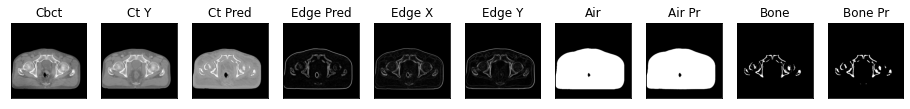

95it [00:37,  2.64it/s]

ssim score = 0.7934944033622742
psnr score = 21.63159942626953
snr score = 12.595232009887695
mae error = 0.03918816149234772
air dice score = 0.994739167101727
bone dice score = 0.8456428292321787
contour dice score = 0.21934089064598083


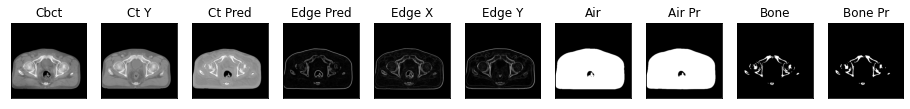

96it [00:37,  2.65it/s]

ssim score = 0.7974455952644348
psnr score = 21.46390151977539
snr score = 12.267776489257812
mae error = 0.039437759667634964
air dice score = 0.9948885510012658
bone dice score = 0.8337858220236232
contour dice score = 0.2600216567516327


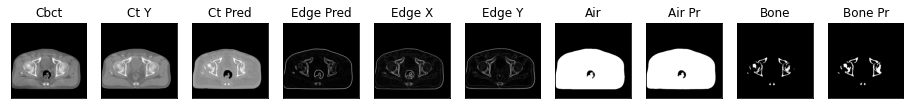

97it [00:38,  2.29it/s]

ssim score = 0.7971395254135132
psnr score = 21.184633255004883
snr score = 11.872081756591797
mae error = 0.04088813066482544
air dice score = 0.99447233715473
bone dice score = 0.8387096774218207
contour dice score = 0.24143555760383606


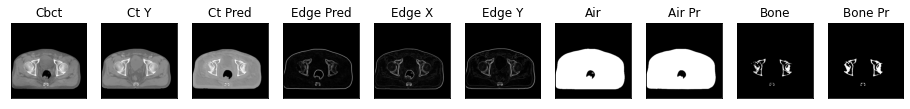

98it [00:38,  2.40it/s]

ssim score = 0.7979169487953186
psnr score = 21.06422233581543
snr score = 11.706576347351074
mae error = 0.041702575981616974
air dice score = 0.9948161801007185
bone dice score = 0.8747972275494057
contour dice score = 0.2585924565792084


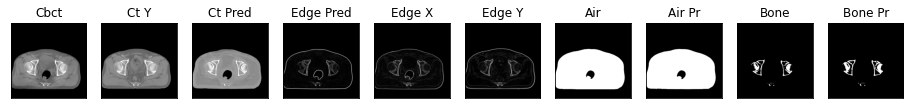

99it [00:38,  2.46it/s]

ssim score = 0.7977748513221741
psnr score = 20.849790573120117
snr score = 11.498817443847656
mae error = 0.04190713167190552
air dice score = 0.994717105534269
bone dice score = 0.9009036605927262
contour dice score = 0.26243847608566284


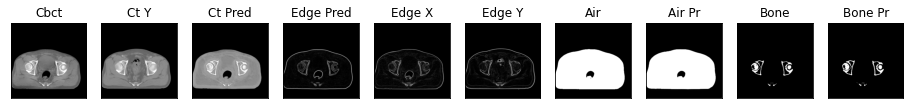

100it [00:39,  2.52it/s]

ssim score = 0.8043752312660217
psnr score = 20.83106803894043
snr score = 11.510201454162598
mae error = 0.04072783887386322
air dice score = 0.9947983751114677
bone dice score = 0.9198606271789144
contour dice score = 0.2572523355484009


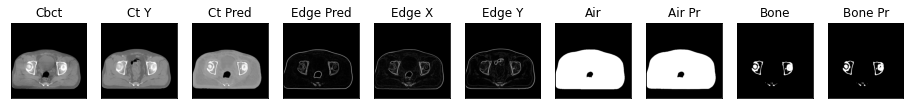

101it [00:39,  2.57it/s]

ssim score = 0.8101853132247925
psnr score = 21.29511833190918
snr score = 11.931663513183594
mae error = 0.038491472601890564
air dice score = 0.9947490334759463
bone dice score = 0.9092127303197787
contour dice score = 0.2620614171028137


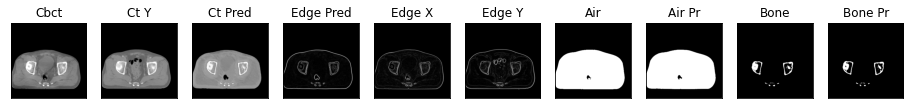

102it [00:39,  2.60it/s]

ssim score = 0.8120371103286743
psnr score = 21.30791473388672
snr score = 11.854256629943848
mae error = 0.03842015564441681
air dice score = 0.9949020127118686
bone dice score = 0.8959798089075901
contour dice score = 0.2608219087123871


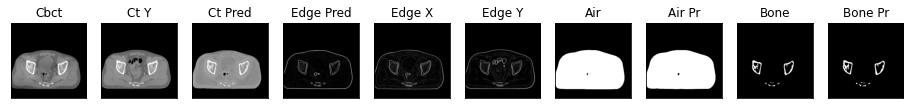

103it [00:40,  2.61it/s]

ssim score = 0.8140653967857361
psnr score = 21.04930877685547
snr score = 11.529924392700195
mae error = 0.0395379364490509
air dice score = 0.9950488424996696
bone dice score = 0.8977186311806518
contour dice score = 0.25838372111320496


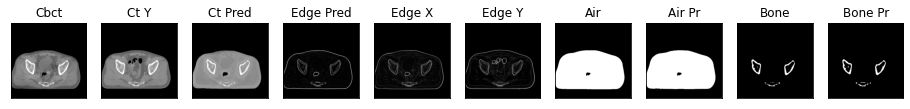

104it [00:40,  2.64it/s]

ssim score = 0.8101494908332825
psnr score = 20.87057113647461
snr score = 11.350883483886719
mae error = 0.04033786430954933
air dice score = 0.994724956181749
bone dice score = 0.9016697588142745
contour dice score = 0.2709251046180725


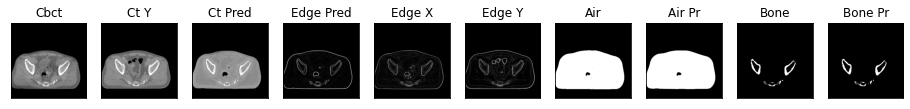

105it [00:41,  2.65it/s]

ssim score = 0.804949939250946
psnr score = 20.83739471435547
snr score = 11.393876075744629
mae error = 0.04041973128914833
air dice score = 0.9949055528623352
bone dice score = 0.8983390607116504
contour dice score = 0.283342570066452


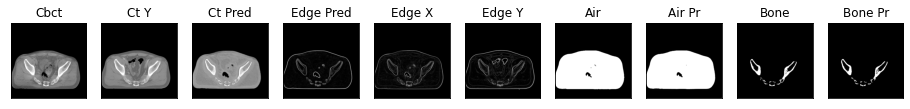

106it [00:41,  2.30it/s]

ssim score = 0.8058770895004272
psnr score = 20.8204345703125
snr score = 11.412496566772461
mae error = 0.04120763763785362
air dice score = 0.9951212831881172
bone dice score = 0.8782620576598134
contour dice score = 0.2784530520439148


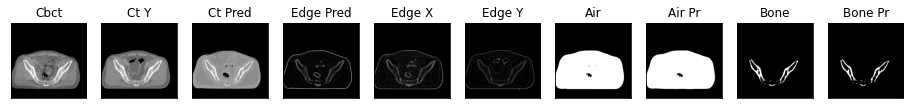

107it [00:42,  2.38it/s]

ssim score = 0.8080427050590515
psnr score = 20.93958282470703
snr score = 11.46994686126709
mae error = 0.04124589264392853
air dice score = 0.9950585399449078
bone dice score = 0.8670569755837918
contour dice score = 0.25874513387680054


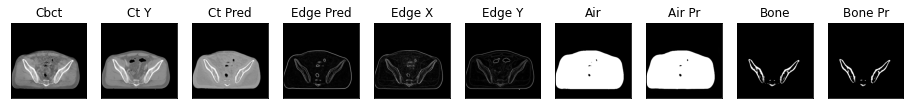

108it [00:42,  2.47it/s]

ssim score = 0.8099834322929382
psnr score = 20.866243362426758
snr score = 11.335346221923828
mae error = 0.04164954274892807
air dice score = 0.9947064234514165
bone dice score = 0.8737120989126624
contour dice score = 0.21400560438632965


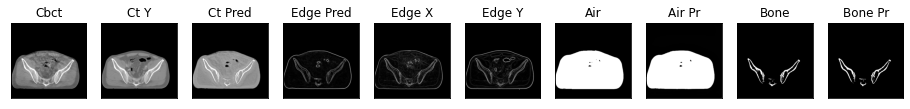

109it [00:42,  2.53it/s]

ssim score = 0.7729069590568542
psnr score = 20.998363494873047
snr score = 12.695669174194336
mae error = 0.04046209156513214
air dice score = 0.9930899026872642
bone dice score = 0.9370800244368638
contour dice score = 0.2112240344285965


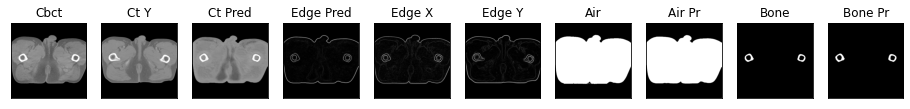

110it [00:43,  2.56it/s]

ssim score = 0.7607048749923706
psnr score = 20.765403747558594
snr score = 12.567001342773438
mae error = 0.04212082549929619
air dice score = 0.9933135303376411
bone dice score = 0.9354572919545329
contour dice score = 0.22330960631370544


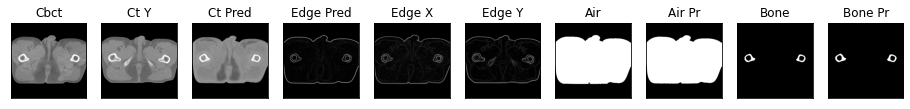

111it [00:43,  2.57it/s]

ssim score = 0.7564254403114319
psnr score = 20.681228637695312
snr score = 12.610783576965332
mae error = 0.043365079909563065
air dice score = 0.9934252035828257
bone dice score = 0.9151275285858591
contour dice score = 0.21165919303894043


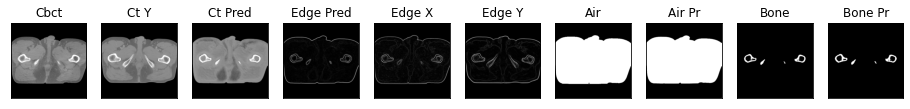

112it [00:43,  2.61it/s]

ssim score = 0.7490854263305664
psnr score = 20.39426612854004
snr score = 12.356107711791992
mae error = 0.04438399150967598
air dice score = 0.9935141682788181
bone dice score = 0.9254087193473194
contour dice score = 0.20891490578651428


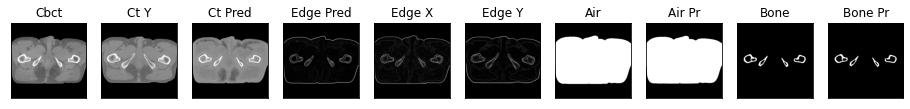

113it [00:44,  2.63it/s]

ssim score = 0.735092282295227
psnr score = 20.11569595336914
snr score = 12.10777473449707
mae error = 0.046486616134643555
air dice score = 0.9936607535552009
bone dice score = 0.9054758800536917
contour dice score = 0.21157324314117432


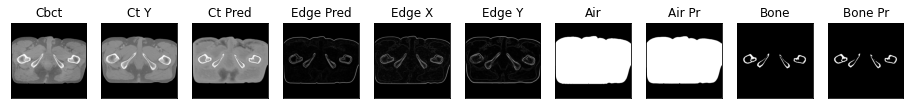

114it [00:44,  2.64it/s]

ssim score = 0.7314227819442749
psnr score = 20.011157989501953
snr score = 12.037656784057617
mae error = 0.04733259230852127
air dice score = 0.9937857698221118
bone dice score = 0.9043423536830657
contour dice score = 0.21105071902275085


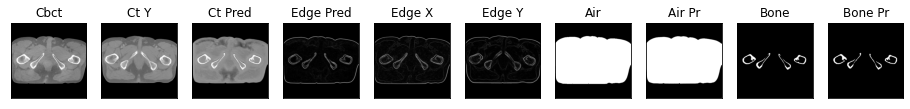

115it [00:45,  2.63it/s]

ssim score = 0.7273549437522888
psnr score = 19.80267906188965
snr score = 11.849488258361816
mae error = 0.048479706048965454
air dice score = 0.9936646946476023
bone dice score = 0.9009387697926168
contour dice score = 0.23587889969348907


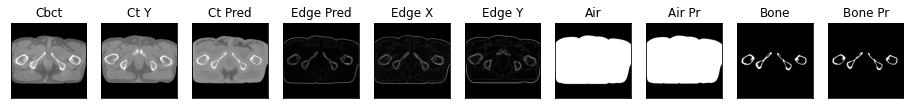

116it [00:45,  2.26it/s]

ssim score = 0.7251933217048645
psnr score = 19.756580352783203
snr score = 11.842460632324219
mae error = 0.048474546521902084
air dice score = 0.9930400907055889
bone dice score = 0.8977989625697771
contour dice score = 0.2460709512233734


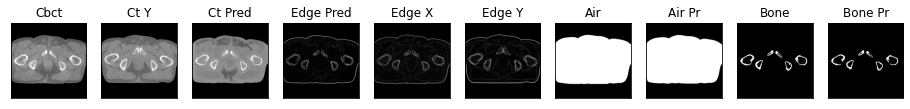

117it [00:46,  2.37it/s]

ssim score = 0.7246687412261963
psnr score = 19.843769073486328
snr score = 11.978330612182617
mae error = 0.047951895743608475
air dice score = 0.9925813953488415
bone dice score = 0.9001506642939303
contour dice score = 0.23944275081157684


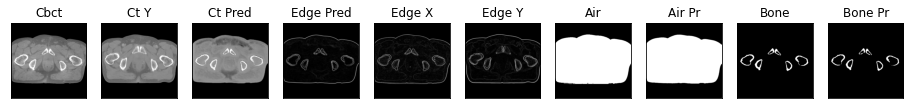

118it [00:46,  2.45it/s]

ssim score = 0.713925838470459
psnr score = 19.727975845336914
snr score = 11.885148048400879
mae error = 0.04938043653964996
air dice score = 0.9927132846002809
bone dice score = 0.9025356576874995
contour dice score = 0.23499362170696259


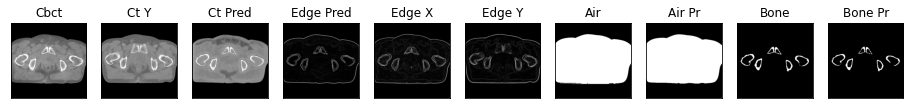

119it [00:46,  2.50it/s]

ssim score = 0.7059289216995239
psnr score = 19.661592483520508
snr score = 11.861543655395508
mae error = 0.05078667774796486
air dice score = 0.993187260466981
bone dice score = 0.8882578096075039
contour dice score = 0.23614662885665894


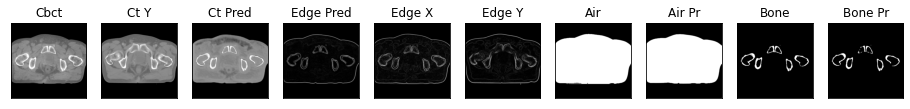

120it [00:47,  2.55it/s]

ssim score = 0.7015405893325806
psnr score = 19.732038497924805
snr score = 11.990325927734375
mae error = 0.0515717975795269
air dice score = 0.9929942196531832
bone dice score = 0.8898468519581412
contour dice score = 0.25011369585990906


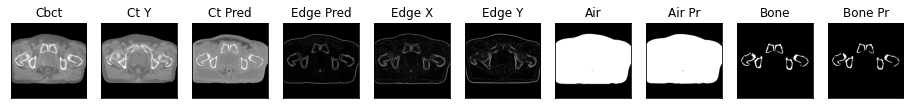

121it [00:47,  2.58it/s]

ssim score = 0.696916937828064
psnr score = 19.51651954650879
snr score = 11.69943618774414
mae error = 0.05353883281350136
air dice score = 0.9934568050959571
bone dice score = 0.8524205587561055
contour dice score = 0.24668797850608826


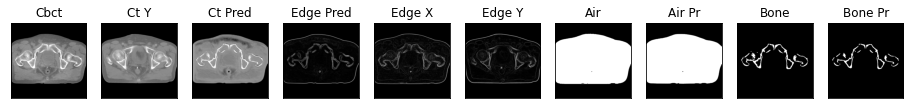

122it [00:47,  2.61it/s]

ssim score = 0.7066319584846497
psnr score = 19.325843811035156
snr score = 11.401540756225586
mae error = 0.05578296631574631
air dice score = 0.9932316150567728
bone dice score = 0.8299132642285814
contour dice score = 0.24370132386684418


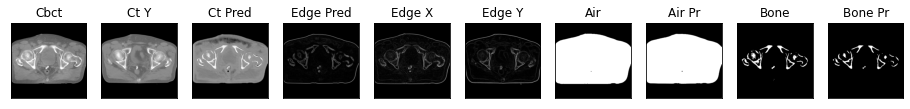

123it [00:48,  2.61it/s]

ssim score = 0.7141084671020508
psnr score = 19.49494743347168
snr score = 11.447558403015137
mae error = 0.05507098510861397
air dice score = 0.9934678305104379
bone dice score = 0.7843307001430112
contour dice score = 0.24529168009757996


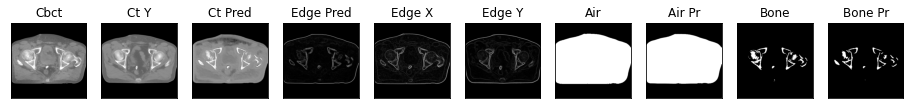

124it [00:48,  2.62it/s]

ssim score = 0.7207115888595581
psnr score = 19.62160873413086
snr score = 11.461791038513184
mae error = 0.054173123091459274
air dice score = 0.9939866524540054
bone dice score = 0.8440166265604461
contour dice score = 0.23062731325626373


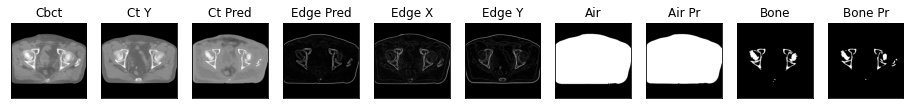

125it [00:49,  2.28it/s]

ssim score = 0.719341516494751
psnr score = 19.55828094482422
snr score = 11.347814559936523
mae error = 0.05446657910943031
air dice score = 0.9940931504939833
bone dice score = 0.8911571935114305
contour dice score = 0.2130616009235382


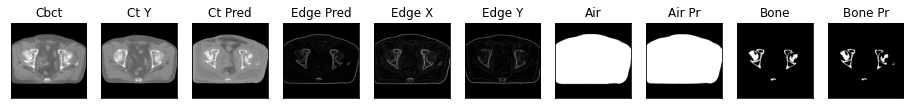

126it [00:49,  2.38it/s]

ssim score = 0.7210493087768555
psnr score = 19.52806854248047
snr score = 11.349756240844727
mae error = 0.05346333235502243
air dice score = 0.9940833231321697
bone dice score = 0.889797773234608
contour dice score = 0.20046620070934296


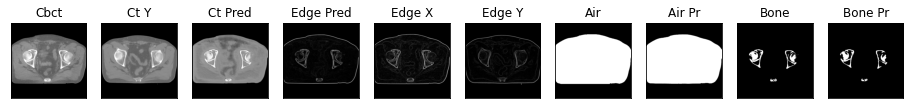

127it [00:49,  2.44it/s]

ssim score = 0.7198744416236877
psnr score = 19.425735473632812
snr score = 11.260902404785156
mae error = 0.05358582362532616
air dice score = 0.9938955513025396
bone dice score = 0.903100775194972
contour dice score = 0.18360655009746552


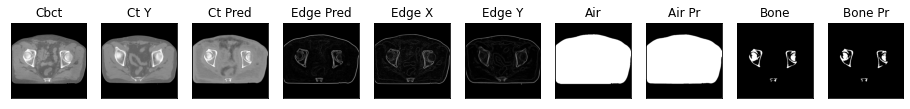

128it [00:50,  2.51it/s]

ssim score = 0.7205370664596558
psnr score = 19.17171287536621
snr score = 10.865385055541992
mae error = 0.05542023852467537
air dice score = 0.993651410045956
bone dice score = 0.8910058146741184
contour dice score = 0.15486307442188263


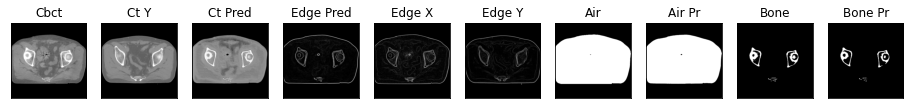

129it [00:50,  2.56it/s]

ssim score = 0.7326049208641052
psnr score = 19.2984561920166
snr score = 10.932823181152344
mae error = 0.05319749191403389
air dice score = 0.9938030700820775
bone dice score = 0.9152022315214058
contour dice score = 0.1410984843969345


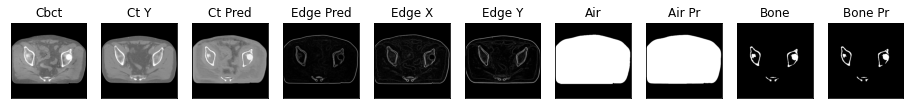

130it [00:51,  2.59it/s]

ssim score = 0.7319551706314087
psnr score = 19.531108856201172
snr score = 11.191123962402344
mae error = 0.051190175116062164
air dice score = 0.9938324420677398
bone dice score = 0.8833755885569834
contour dice score = 0.13371266424655914


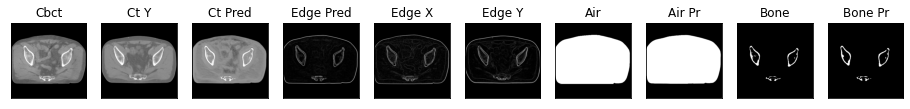

131it [00:51,  2.59it/s]

ssim score = 0.7298191785812378
psnr score = 19.53333854675293
snr score = 11.266165733337402
mae error = 0.05041932314634323
air dice score = 0.9933685417961136
bone dice score = 0.9042132416181563
contour dice score = 0.12049335986375809


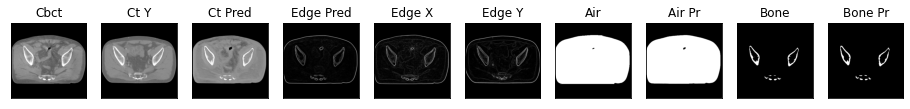

132it [00:51,  2.62it/s]

ssim score = 0.7232271432876587
psnr score = 19.459627151489258
snr score = 11.321686744689941
mae error = 0.050586674362421036
air dice score = 0.9933216718061582
bone dice score = 0.9082268108831821
contour dice score = 0.11849020421504974


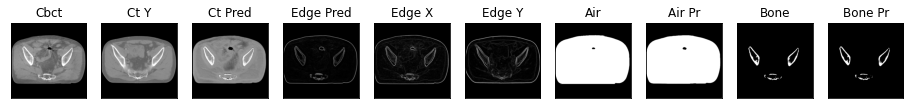

133it [00:52,  2.64it/s]

ssim score = 0.713051438331604
psnr score = 19.297077178955078
snr score = 11.193094253540039
mae error = 0.051275961101055145
air dice score = 0.9932163629548161
bone dice score = 0.8964046313239427
contour dice score = 0.10945751518011093


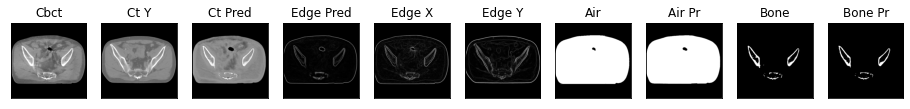

134it [00:52,  2.65it/s]

ssim score = 0.7086920738220215
psnr score = 19.408720016479492
snr score = 11.274947166442871
mae error = 0.05118712782859802
air dice score = 0.9933625502354971
bone dice score = 0.8691819006888476
contour dice score = 0.10698795318603516


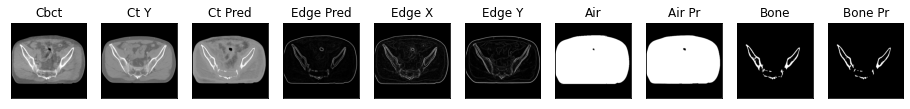

135it [00:53,  2.27it/s]

ssim score = 0.7080780863761902
psnr score = 19.489904403686523
snr score = 11.292755126953125
mae error = 0.050784025341272354
air dice score = 0.9938716698483762
bone dice score = 0.8549905838060937
contour dice score = 0.11035817861557007


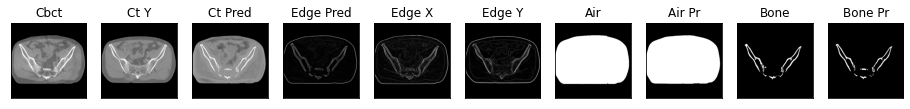

136it [00:53,  2.38it/s]

ssim score = 0.7732044458389282
psnr score = 21.42776870727539
snr score = 12.905160903930664
mae error = 0.03804139420390129
air dice score = 0.994897693161423
bone dice score = 0.889025439352476
contour dice score = 0.18364274501800537


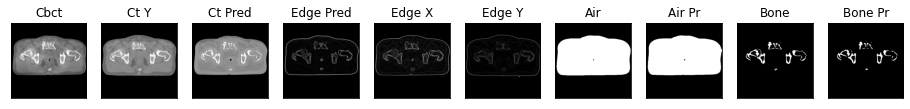

137it [00:53,  2.46it/s]

ssim score = 0.7772982120513916
psnr score = 21.55086326599121
snr score = 13.068264961242676
mae error = 0.03715643286705017
air dice score = 0.9948421673347255
bone dice score = 0.8726587052184456
contour dice score = 0.16767676174640656


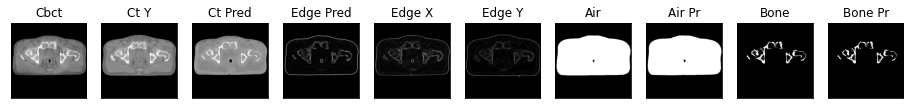

138it [00:54,  2.52it/s]

ssim score = 0.7857460975646973
psnr score = 21.785865783691406
snr score = 13.311056137084961
mae error = 0.035972315818071365
air dice score = 0.994680692107705
bone dice score = 0.862266112267902
contour dice score = 0.18255577981472015


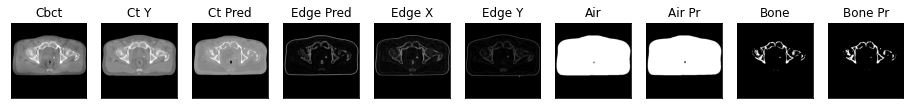

139it [00:54,  2.55it/s]

ssim score = 0.7859765887260437
psnr score = 21.664825439453125
snr score = 13.131595611572266
mae error = 0.03664188086986542
air dice score = 0.9946253888534953
bone dice score = 0.8584619122845527
contour dice score = 0.17886178195476532


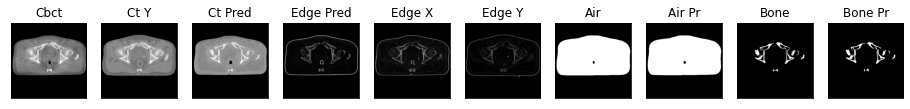

140it [00:55,  2.59it/s]

ssim score = 0.7925765514373779
psnr score = 21.583480834960938
snr score = 12.89462661743164
mae error = 0.036794278770685196
air dice score = 0.9946235346312086
bone dice score = 0.8541084404715747
contour dice score = 0.1541602909564972


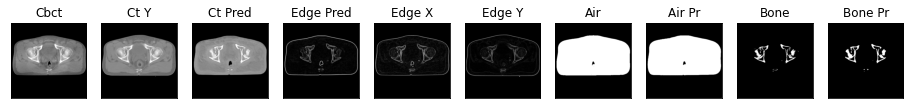

141it [00:55,  2.61it/s]

ssim score = 0.7981265783309937
psnr score = 21.691587448120117
snr score = 12.981928825378418
mae error = 0.03613315895199776
air dice score = 0.9947771036665827
bone dice score = 0.8825191764246734
contour dice score = 0.17093142867088318


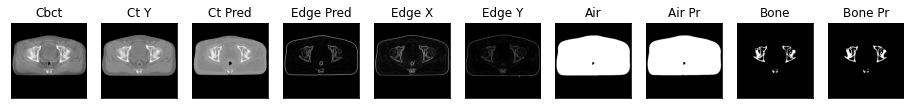

142it [00:55,  2.63it/s]

ssim score = 0.7964478731155396
psnr score = 21.58826446533203
snr score = 12.86297607421875
mae error = 0.0367581881582737
air dice score = 0.9948137171888269
bone dice score = 0.8907404918708407
contour dice score = 0.17556467652320862


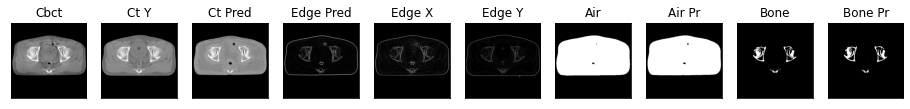

143it [00:56,  2.62it/s]

ssim score = 0.7932616472244263
psnr score = 21.10293960571289
snr score = 12.387014389038086
mae error = 0.038257796317338943
air dice score = 0.9943714821763645
bone dice score = 0.891005578991822
contour dice score = 0.1805054098367691


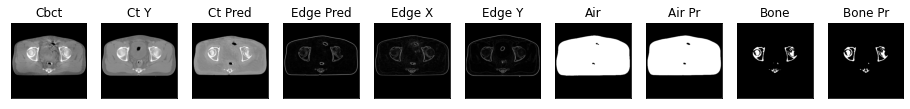

144it [00:56,  2.27it/s]

ssim score = 0.7879561185836792
psnr score = 21.155086517333984
snr score = 12.494945526123047
mae error = 0.03742201626300812
air dice score = 0.9942253703295159
bone dice score = 0.9059195165512166
contour dice score = 0.1748577356338501


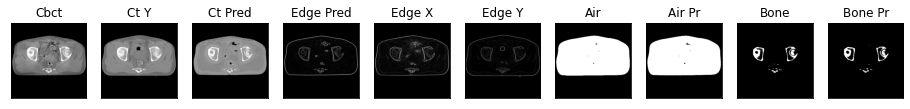

145it [00:57,  2.37it/s]

ssim score = 0.7900075912475586
psnr score = 21.00062370300293
snr score = 12.318552017211914
mae error = 0.037904758006334305
air dice score = 0.9939054697835227
bone dice score = 0.9037800687299
contour dice score = 0.19032761454582214


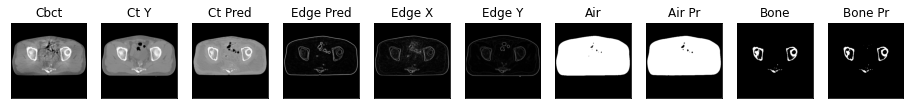

146it [00:57,  2.46it/s]

ssim score = 0.7905381917953491
psnr score = 20.481002807617188
snr score = 11.728157997131348
mae error = 0.03920267894864082
air dice score = 0.9941706168407856
bone dice score = 0.8887176325541196
contour dice score = 0.20783290266990662


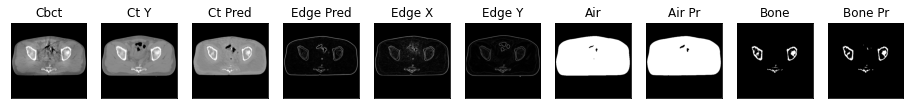

147it [00:57,  2.51it/s]

ssim score = 0.7908506393432617
psnr score = 20.56787109375
snr score = 11.77113151550293
mae error = 0.03874504193663597
air dice score = 0.9941117312431432
bone dice score = 0.8975971617497566
contour dice score = 0.20472441613674164


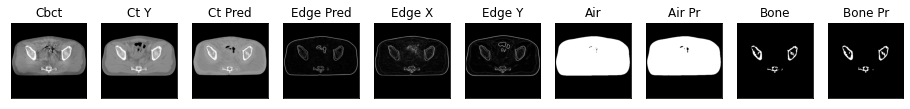

148it [00:58,  2.56it/s]

ssim score = 0.7886351943016052
psnr score = 20.78691864013672
snr score = 11.989084243774414
mae error = 0.03847751021385193
air dice score = 0.9944536882972865
bone dice score = 0.9035742652914444
contour dice score = 0.20537124574184418


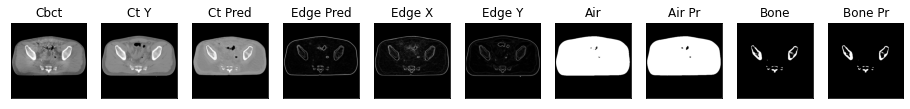

149it [00:58,  2.60it/s]

ssim score = 0.78426593542099
psnr score = 20.747230529785156
snr score = 11.962751388549805
mae error = 0.03904390335083008
air dice score = 0.9932633339528021
bone dice score = 0.9036071536843951
contour dice score = 0.20485743880271912


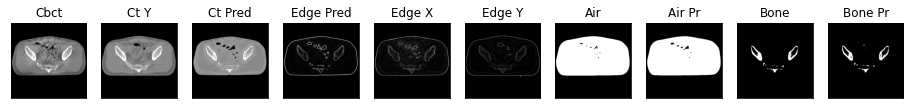

150it [00:59,  2.63it/s]

ssim score = 0.7810754776000977
psnr score = 20.755653381347656
snr score = 12.026378631591797
mae error = 0.03934072330594063
air dice score = 0.9934592740649768
bone dice score = 0.9017038007876579
contour dice score = 0.20095187425613403


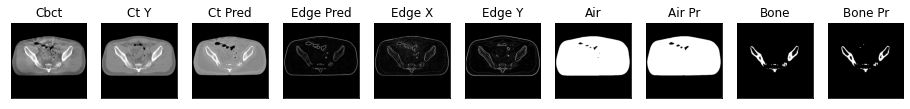

151it [00:59,  2.64it/s]

ssim score = 0.7786436080932617
psnr score = 20.39830207824707
snr score = 11.688398361206055
mae error = 0.04070510342717171
air dice score = 0.9930162590219699
bone dice score = 0.8787341426834165
contour dice score = 0.21091680228710175


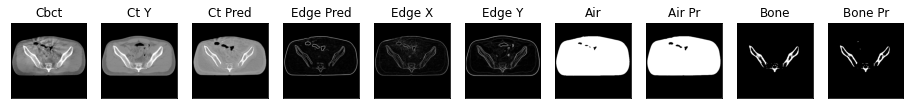

152it [00:59,  2.65it/s]

ssim score = 0.7799193263053894
psnr score = 20.373950958251953
snr score = 11.609306335449219
mae error = 0.04101809859275818
air dice score = 0.9927041400306841
bone dice score = 0.8648570184371482
contour dice score = 0.15417331457138062


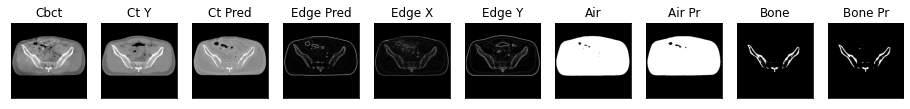

153it [01:00,  2.66it/s]

ssim score = 0.7828839421272278
psnr score = 20.408340454101562
snr score = 11.607345581054688
mae error = 0.041526734828948975
air dice score = 0.9935138666376371
bone dice score = 0.8658623136995619
contour dice score = 0.150480255484581


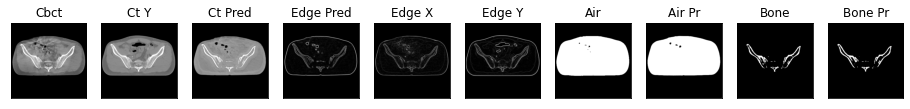

154it [01:00,  2.29it/s]

ssim score = 0.7824291586875916
psnr score = 20.46525001525879
snr score = 11.664325714111328
mae error = 0.04164493829011917
air dice score = 0.9942125488121768
bone dice score = 0.8560168155562793
contour dice score = 0.16818425059318542


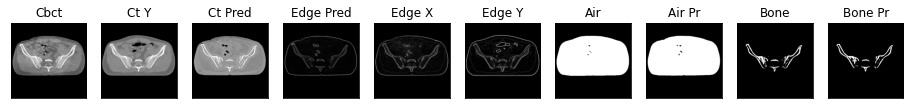

155it [01:01,  2.40it/s]

ssim score = 0.7773314118385315
psnr score = 20.496118545532227
snr score = 11.693772315979004
mae error = 0.042273662984371185
air dice score = 0.9939292867106756
bone dice score = 0.8658425504246474
contour dice score = 0.16388140618801117


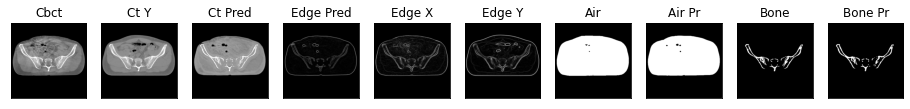

156it [01:01,  2.48it/s]

ssim score = 0.7684704661369324
psnr score = 20.098316192626953
snr score = 11.301010131835938
mae error = 0.04449169337749481
air dice score = 0.992927554373343
bone dice score = 0.8553675304091041
contour dice score = 0.17768147587776184


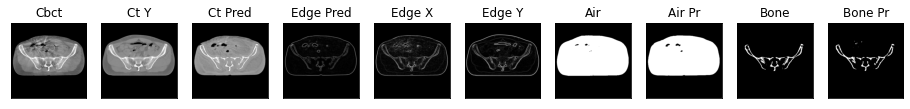

157it [01:01,  2.53it/s]

ssim score = 0.7656214237213135
psnr score = 19.7734375
snr score = 10.958857536315918
mae error = 0.04652416333556175
air dice score = 0.9918435727825515
bone dice score = 0.8373972787304675
contour dice score = 0.17675940692424774


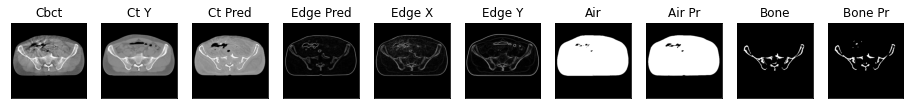

158it [01:02,  2.57it/s]

ssim score = 0.7601781487464905
psnr score = 19.598880767822266
snr score = 10.765676498413086
mae error = 0.04810013622045517
air dice score = 0.9923784577028132
bone dice score = 0.8210743269377679
contour dice score = 0.18660812079906464


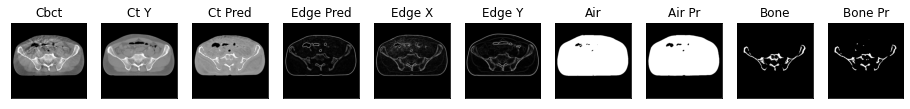

159it [01:02,  2.61it/s]

ssim score = 0.7522375583648682
psnr score = 19.307804107666016
snr score = 10.428661346435547
mae error = 0.05050000920891762
air dice score = 0.9926993427824905
bone dice score = 0.8274490303353127
contour dice score = 0.19126589596271515


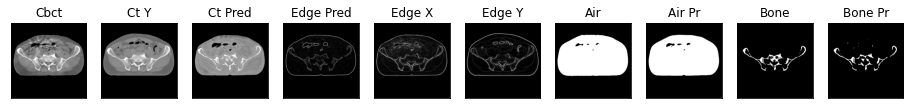

160it [01:02,  2.63it/s]

ssim score = 0.7507033944129944
psnr score = 19.33160972595215
snr score = 10.398670196533203
mae error = 0.05088137090206146
air dice score = 0.992197876486267
bone dice score = 0.8457711442804784
contour dice score = 0.18333333730697632


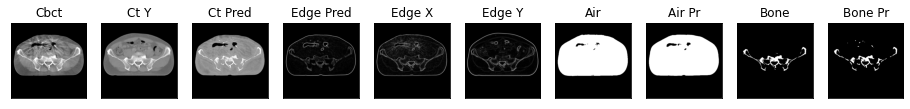

161it [01:03,  2.64it/s]

ssim score = 0.7479280233383179
psnr score = 19.13016128540039
snr score = 10.227685928344727
mae error = 0.05257939174771309
air dice score = 0.9922769130014677
bone dice score = 0.8509756097579149
contour dice score = 0.20066890120506287


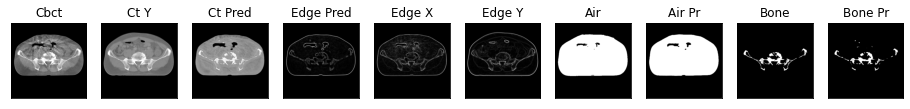

162it [01:03,  2.63it/s]

ssim score = 0.7441383004188538
psnr score = 18.93069076538086
snr score = 9.97298812866211
mae error = 0.05404914170503616
air dice score = 0.992776635656068
bone dice score = 0.8450990350451358
contour dice score = 0.2161559909582138


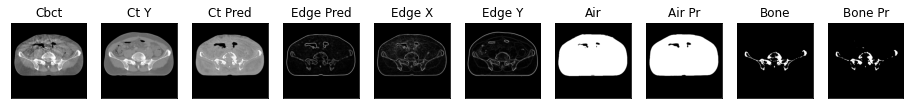

163it [01:04,  2.29it/s]

ssim score = 0.7547371983528137
psnr score = 19.310800552368164
snr score = 10.20556640625
mae error = 0.05249715596437454
air dice score = 0.9935914360463772
bone dice score = 0.8690046415695074
contour dice score = 0.15014006197452545


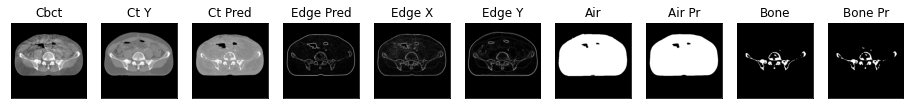

164it [01:04,  2.39it/s]

ssim score = 0.791723906993866
psnr score = 20.732261657714844
snr score = 11.113174438476562
mae error = 0.049707699567079544
air dice score = 0.993511207241379
bone dice score = 0.9033581133067583
contour dice score = 0.16027197241783142


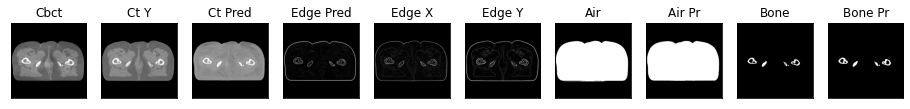

165it [01:05,  2.48it/s]

ssim score = 0.7906742095947266
psnr score = 20.82114028930664
snr score = 11.323062896728516
mae error = 0.04908941313624382
air dice score = 0.9931700423928453
bone dice score = 0.9082969432334433
contour dice score = 0.1524752527475357


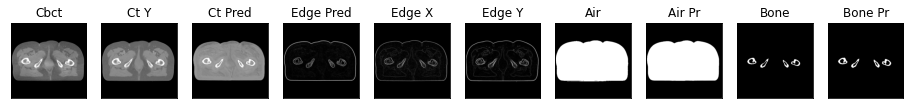

166it [01:05,  2.53it/s]

ssim score = 0.7842850089073181
psnr score = 20.826990127563477
snr score = 11.411829948425293
mae error = 0.04902117699384689
air dice score = 0.9931401658646513
bone dice score = 0.883847197985576
contour dice score = 0.11638142168521881


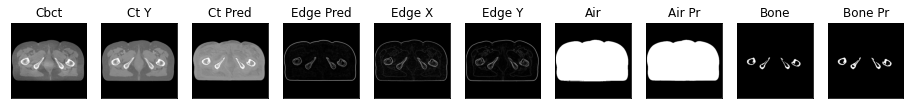

167it [01:05,  2.57it/s]

ssim score = 0.7798063158988953
psnr score = 20.834609985351562
snr score = 11.48289680480957
mae error = 0.04904571920633316
air dice score = 0.993048630471024
bone dice score = 0.8947461524872679
contour dice score = 0.15730337798595428


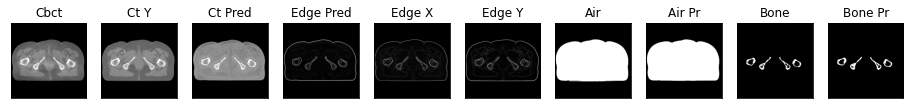

168it [01:06,  2.60it/s]

ssim score = 0.7786775827407837
psnr score = 20.828237533569336
snr score = 11.504985809326172
mae error = 0.04872865229845047
air dice score = 0.9930505179467886
bone dice score = 0.9136566907479591
contour dice score = 0.12992125749588013


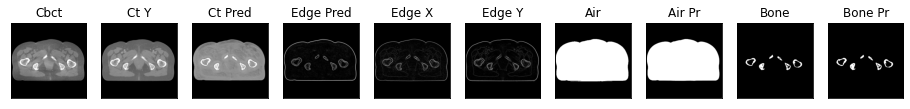

169it [01:06,  2.63it/s]

ssim score = 0.7786691188812256
psnr score = 20.760595321655273
snr score = 11.460296630859375
mae error = 0.04902792349457741
air dice score = 0.9930399803209473
bone dice score = 0.9131442839323498
contour dice score = 0.129566490650177


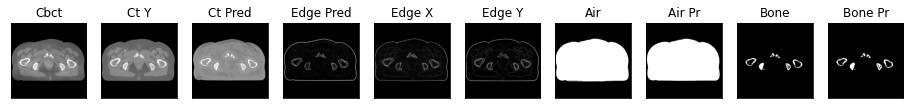

170it [01:06,  2.65it/s]

ssim score = 0.7743681073188782
psnr score = 20.718000411987305
snr score = 11.449027061462402
mae error = 0.04917815700173378
air dice score = 0.9929618641314991
bone dice score = 0.9051223376182869
contour dice score = 0.11417513340711594


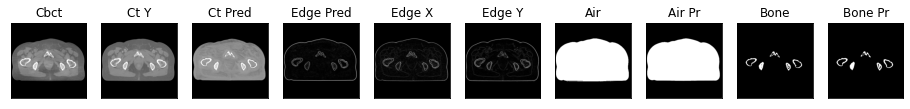

171it [01:07,  2.66it/s]

ssim score = 0.7708163857460022
psnr score = 20.642650604248047
snr score = 11.422043800354004
mae error = 0.04969632253050804
air dice score = 0.9926588303165842
bone dice score = 0.9066067104824177
contour dice score = 0.11576470732688904


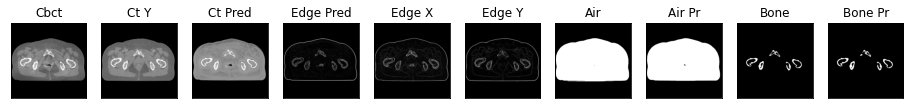

172it [01:07,  2.67it/s]

ssim score = 0.7691637873649597
psnr score = 20.55621910095215
snr score = 11.378355026245117
mae error = 0.04989979788661003
air dice score = 0.9923635471251481
bone dice score = 0.9021456436946985
contour dice score = 0.119345523416996


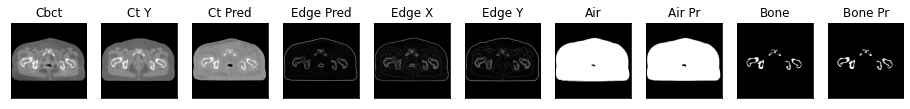

173it [01:08,  2.30it/s]

ssim score = 0.7655069828033447
psnr score = 20.4755802154541
snr score = 11.385419845581055
mae error = 0.0503070242702961
air dice score = 0.9919711191335798
bone dice score = 0.8856860251535158
contour dice score = 0.118691585958004


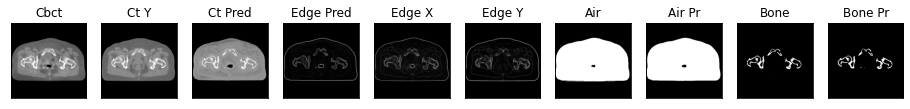

174it [01:08,  2.40it/s]

ssim score = 0.7712636590003967
psnr score = 21.038000106811523
snr score = 12.061113357543945
mae error = 0.04740925878286362
air dice score = 0.9923067529612951
bone dice score = 0.8878869120169645
contour dice score = 0.09602954983711243


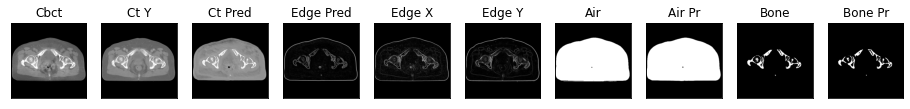

175it [01:08,  2.48it/s]

ssim score = 0.7714523673057556
psnr score = 20.652820587158203
snr score = 11.547383308410645
mae error = 0.048759497702121735
air dice score = 0.9918779971486644
bone dice score = 0.8623564574506473
contour dice score = 0.1111111119389534


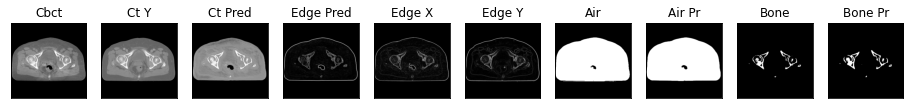

176it [01:09,  2.53it/s]

ssim score = 0.7754838466644287
psnr score = 20.57253074645996
snr score = 11.357669830322266
mae error = 0.04947016015648842
air dice score = 0.9922166112765677
bone dice score = 0.8502994012002413
contour dice score = 0.11401869356632233


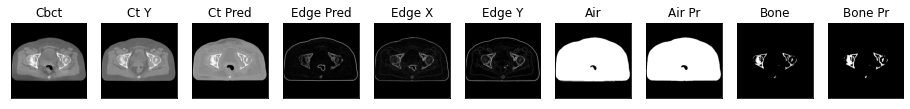

177it [01:09,  2.56it/s]

ssim score = 0.7777224183082581
psnr score = 20.57406234741211
snr score = 11.332074165344238
mae error = 0.05001608654856682
air dice score = 0.9925281092244203
bone dice score = 0.8864564613643774
contour dice score = 0.13308857381343842


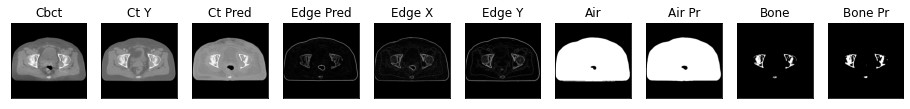

178it [01:10,  2.59it/s]

ssim score = 0.78432297706604
psnr score = 20.783750534057617
snr score = 11.533758163452148
mae error = 0.04988182336091995
air dice score = 0.9928570920902118
bone dice score = 0.9096463022522565
contour dice score = 0.12716221809387207


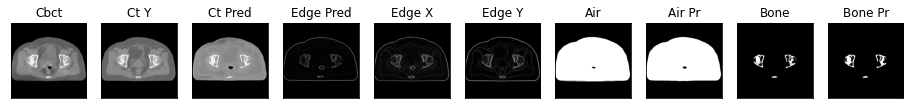

179it [01:10,  2.62it/s]

ssim score = 0.7822011709213257
psnr score = 20.985013961791992
snr score = 11.769248962402344
mae error = 0.049529049545526505
air dice score = 0.9932312026765323
bone dice score = 0.9168108193125206
contour dice score = 0.11603773385286331


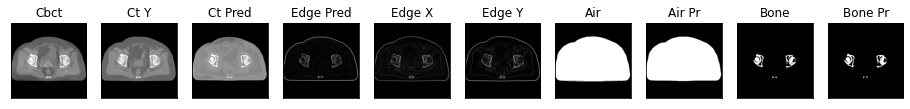

180it [01:10,  2.64it/s]

ssim score = 0.7807223200798035
psnr score = 20.783823013305664
snr score = 11.619549751281738
mae error = 0.050525981932878494
air dice score = 0.9936385879063309
bone dice score = 0.9260035466721586
contour dice score = 0.11555127799510956


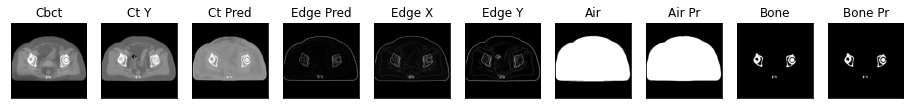

181it [01:11,  2.65it/s]

ssim score = 0.7677194476127625
psnr score = 20.5463809967041
snr score = 11.419668197631836
mae error = 0.050660908222198486
air dice score = 0.9937254303800145
bone dice score = 0.9287798180894323
contour dice score = 0.11901306360960007


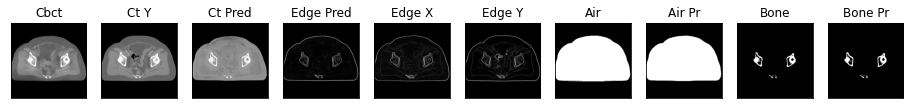

182it [01:11,  2.30it/s]

ssim score = 0.7520446181297302
psnr score = 19.725770950317383
snr score = 10.526619911193848
mae error = 0.055053964257240295
air dice score = 0.9930146932314834
bone dice score = 0.9006042925630213
contour dice score = 0.11655239760875702


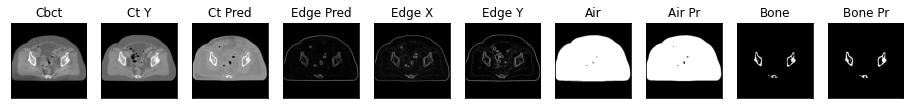

183it [01:12,  2.40it/s]

ssim score = 0.7475050687789917
psnr score = 19.488096237182617
snr score = 10.270953178405762
mae error = 0.05701811984181404
air dice score = 0.9927558063102592
bone dice score = 0.9016152716613884
contour dice score = 0.1256803572177887


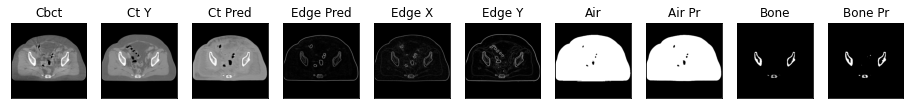

184it [01:12,  2.48it/s]

ssim score = 0.7485997080802917
psnr score = 19.897268295288086
snr score = 10.745038986206055
mae error = 0.05588632822036743
air dice score = 0.9927098295346807
bone dice score = 0.9067262751492232
contour dice score = 0.1108362227678299


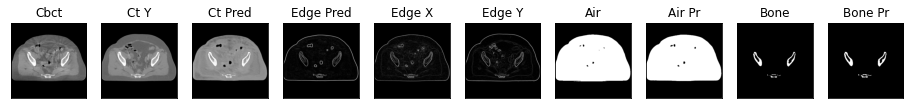

185it [01:12,  2.54it/s]

ssim score = 0.7476397752761841
psnr score = 19.950172424316406
snr score = 10.85303783416748
mae error = 0.05558444932103157
air dice score = 0.9921753789736031
bone dice score = 0.9204052098422503
contour dice score = 0.10961633920669556


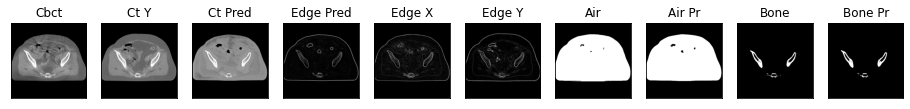

186it [01:13,  2.58it/s]

ssim score = 0.740502655506134
psnr score = 19.46881675720215
snr score = 10.436111450195312
mae error = 0.05824479088187218
air dice score = 0.9924121007375143
bone dice score = 0.9145852605625256
contour dice score = 0.09837678074836731


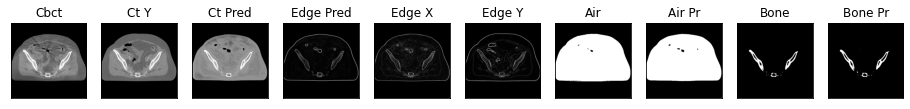

187it [01:13,  2.61it/s]

ssim score = 0.7375034093856812
psnr score = 19.345523834228516
snr score = 10.385679244995117
mae error = 0.05902581289410591
air dice score = 0.9921939438729439
bone dice score = 0.907123788114274
contour dice score = 0.09481481462717056


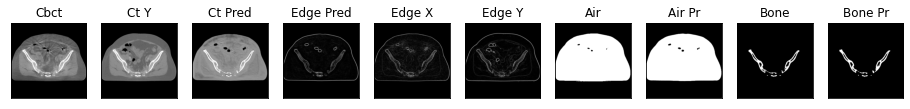

188it [01:14,  2.63it/s]

ssim score = 0.7325589656829834
psnr score = 19.24580192565918
snr score = 10.28166675567627
mae error = 0.060273509472608566
air dice score = 0.9913816814889577
bone dice score = 0.8830730265951446
contour dice score = 0.09290953725576401


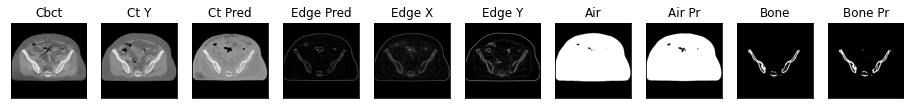

189it [01:14,  2.64it/s]

ssim score = 0.7311908006668091
psnr score = 19.292943954467773
snr score = 10.306632995605469
mae error = 0.06075844541192055
air dice score = 0.9925339278538979
bone dice score = 0.8842818428199962
contour dice score = 0.095238097012043


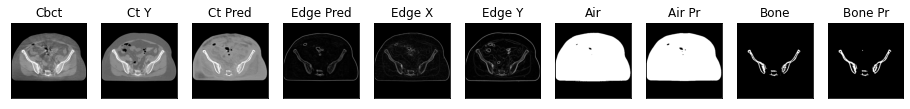

190it [01:14,  2.66it/s]

ssim score = 0.7398048043251038
psnr score = 19.732187271118164
snr score = 10.757508277893066
mae error = 0.05872753635048866
air dice score = 0.9929494259368704
bone dice score = 0.886853600114318
contour dice score = 0.08683068305253983


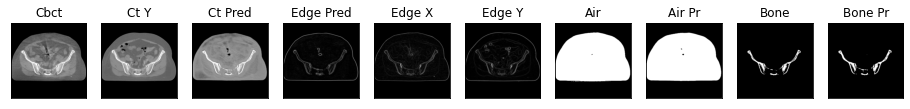

191it [01:15,  2.54it/s]


In [41]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [42]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [43]:
edge_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [44]:
# score_ssim, score_psnr, score_snr, score_mae, score_air, score_bone, score_cont, score_acc
# unmasked
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:07, 24.08it/s]


(0.7825289930348621,
 20.774122128311877,
 11.778394084950392,
 0.043309891976767184,
 0.994099461430868,
 0.8838059781857365,
 0.25340379602934054,
 0.3769633507853403,
 0.5104712041884817)

In [45]:
# import torchvision.models as models
# models.vgg16(pretrained=True)